Banking case study: direct marketing  (campaign response classification model)  

# I Introduction

Objective: This example uses data related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed ('yes') or not ('no'). 

 The goal is to built a classifier to predict if the client will subscribe (yes/no) or not. The bank workers can use this classifier to evaluate clients before calling, thus increase efficacy of bank workers and gain more subscribes after calling. 

In [26]:
# Import libraries needed
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes",labelweight="bold",labelsize="large",titleweight="bold", titlesize=14,titlepad=10,)
plot_params = dict(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",legend=False,)
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style(style='darkgrid', rc={'axes.facecolor': '.9', 'grid.color': '.8'})
sns.set_palette(palette='Set2')
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

from sklearn.feature_selection import mutual_info_classif

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

from imblearn.pipeline import Pipeline 
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
import collections

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, cohen_kappa_score, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
 
import shap
shap.initjs() # print the JS visualization code to the notebook
import pickle 

# II Data read and understanding

In [2]:
bank=pd.read_csv(r'C:\Users\yxm02\.ipynb_checkpoints\git\Bank-Marketing-Campaign-Response-Classification\bank-additional-full.csv', sep=';')
df=bank.copy()
df.head(5)

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [4]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

Insights: 
- 8 client features: (1) age (2) job (3) marital (4) education (5) default (has credit in default?) (6) housing (has housing loan?) (7) loan (has personal loan?)

- 4 features related with the last contact of the current campaign: (1) contact (contact type) (2) month (3) day:DayOfMonth (4) duration in seconds (numeric). 

- 4 campaign attributes: (1) campaign (2) pdays (3) previous: number of contacts performed before this campaign and for this client (numeric) (4) poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

- 5 social and economic context attributes:(1) emp.var.rate (2) cons.price.idx (3) cons.conf.idx (4) euribor3m (5) nr.employed: number of employees - quarterly indicator (numeric)

- y: Output variable (desired target): has the client subscribed a term deposit? (binary: "yes","no")

In [3]:
# Not all variables are self-explanatory. Rename some cols
df.rename(columns={'campaign': 'nCallThisCamp', 'previous': 'nCallBefThisCamp', 'poutcome': 'yLastCamp', 'pdays': 'nDayPassLastCallLastCamp', 'contact': 'CallType', 'duration': 'duration(s)', 'day':'DayOfMonth'}, inplace=True)

In [4]:
df.shape

(41188, 21)

Insights: 41188 rows and 21 columns. Some values are 'unknown'. 

# III Data cleaning

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       41188 non-null  int64  
 1   job                       41188 non-null  object 
 2   marital                   41188 non-null  object 
 3   education                 41188 non-null  object 
 4   default                   41188 non-null  object 
 5   housing                   41188 non-null  object 
 6   loan                      41188 non-null  object 
 7   CallType                  41188 non-null  object 
 8   month                     41188 non-null  object 
 9   day_of_week               41188 non-null  object 
 10  duration(s)               41188 non-null  int64  
 11  nCallThisCamp             41188 non-null  int64  
 12  nDayPassLastCallLastCamp  41188 non-null  int64  
 13  nCallBefThisCamp          41188 non-null  int64  
 14  yLastC

In [206]:
df.isnull().sum()

age                         0
job                         0
marital                     0
education                   0
default                     0
housing                     0
loan                        0
CallType                    0
month                       0
day_of_week                 0
duration(s)                 0
nCallThisCamp               0
nDayPassLastCallLastCamp    0
nCallBefThisCamp            0
yLastCamp                   0
emp.var.rate                0
cons.price.idx              0
cons.conf.idx               0
euribor3m                   0
nr.employed                 0
y                           0
dtype: int64

In [5]:
df=df.drop_duplicates()
df.shape

(41176, 21)

Insights: 
- No null values. 
- 12 duplicates removed. 
- Categorical features are all in dtype 'object'.

# IV Exploratory data analysis (EDA)

## IV.1 Explore categorical variables

In [60]:
# Separate numerical and categorical features
cat_features=[]
num_features=[]
for i in df.columns:
    if df[i].dtype == 'object':
        cat_features.append(i)
    else:
        num_features.append(i)
print('Categorical:', cat_features)
print('Numerical:', num_features)

Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'CallType', 'month', 'day_of_week', 'yLastCamp', 'y']
Numerical: ['age', 'duration(s)', 'nCallThisCamp', 'nDayPassLastCallLastCamp', 'nCallBefThisCamp', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [9]:
# Explore target variable, then other categorical features.
df_y_count=df.y.value_counts().to_frame()
df_y_count['percentage']=df_y_count.y/df.shape[0]
df_y_count

y  percentage
no   36537    0.887337
yes   4639    0.112663

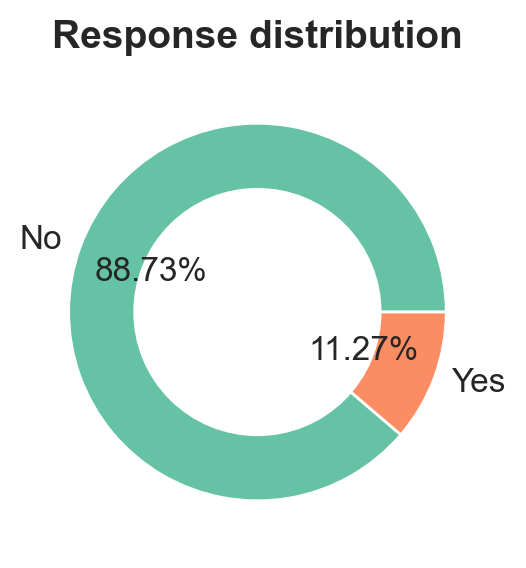

In [210]:
fig = plt.figure(figsize=(3,3))
ax=plt.subplot()
ax.pie(df_y_count['percentage'], wedgeprops={'linewidth': 1, 'edgecolor': 'white'}, colors=sns.color_palette('Set2'), 
       frame=False, labels=['No','Yes'], autopct='%1.2f%%', textprops={'fontsize':12})
plt.title(label= 'Response distribution', fontdict={'fontsize':14}, pad=10)
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)

Insights: 
- Only 11.3% of clients subscribed a term deposit.  
- y distribution is imbalanced.

In [10]:
df.groupby('y').mean()

age  duration(s)  nCallThisCamp  nDayPassLastCallLastCamp  \
y                                                                      
no   39.910994   220.868079       2.633385                984.109396   
yes  40.912266   553.256090       2.051951                791.990946   

     nCallBefThisCamp  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
y                                                                               
no           0.132414      0.248885       93.603798     -40.593232   3.811482   
yes          0.492779     -1.233089       93.354577     -39.791119   2.123362   

     nr.employed  
y                 
no   5176.165690  
yes  5095.120069

Insights:
- Registers age is slightly higher than that of non registered.
- The average duration of call of registers is about 2.5 times higher than that of non registered.
- The pdays (days since the customer was last contacted) is lower for the customers who bought it.
- Number of calls made during current campaign to registers are lower than to non registers, but calls made before current campaign to registers are higher than to non registers.
- emp.var.rate, euribor3m, nr.employed are higher for non-registers.

In [11]:
for i in cat_features[:-1]:
    print(df[i].value_counts(), '\n')

admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64 

married     24921
single      11564
divorced     4611
unknown        80
Name: marital, dtype: int64 

university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: education, dtype: int64 

no         32577
unknown     8596
yes            3
Name: default, dtype: int64 

yes        21571
no         18615
unknown      990
Name: housing, dtype: int64 

no         33938
yes         6248
unknown      990
Name: loan, dtype: int64 

cellular     26135
telephone    15041
Name: CallType, dtype: int64 

may    13767
jul     71

In [12]:
# Visualize other categorical features
c=len(cat_features[:-1])
rows=(c//4)+(c%4>0) 
print(c, rows)

10 3


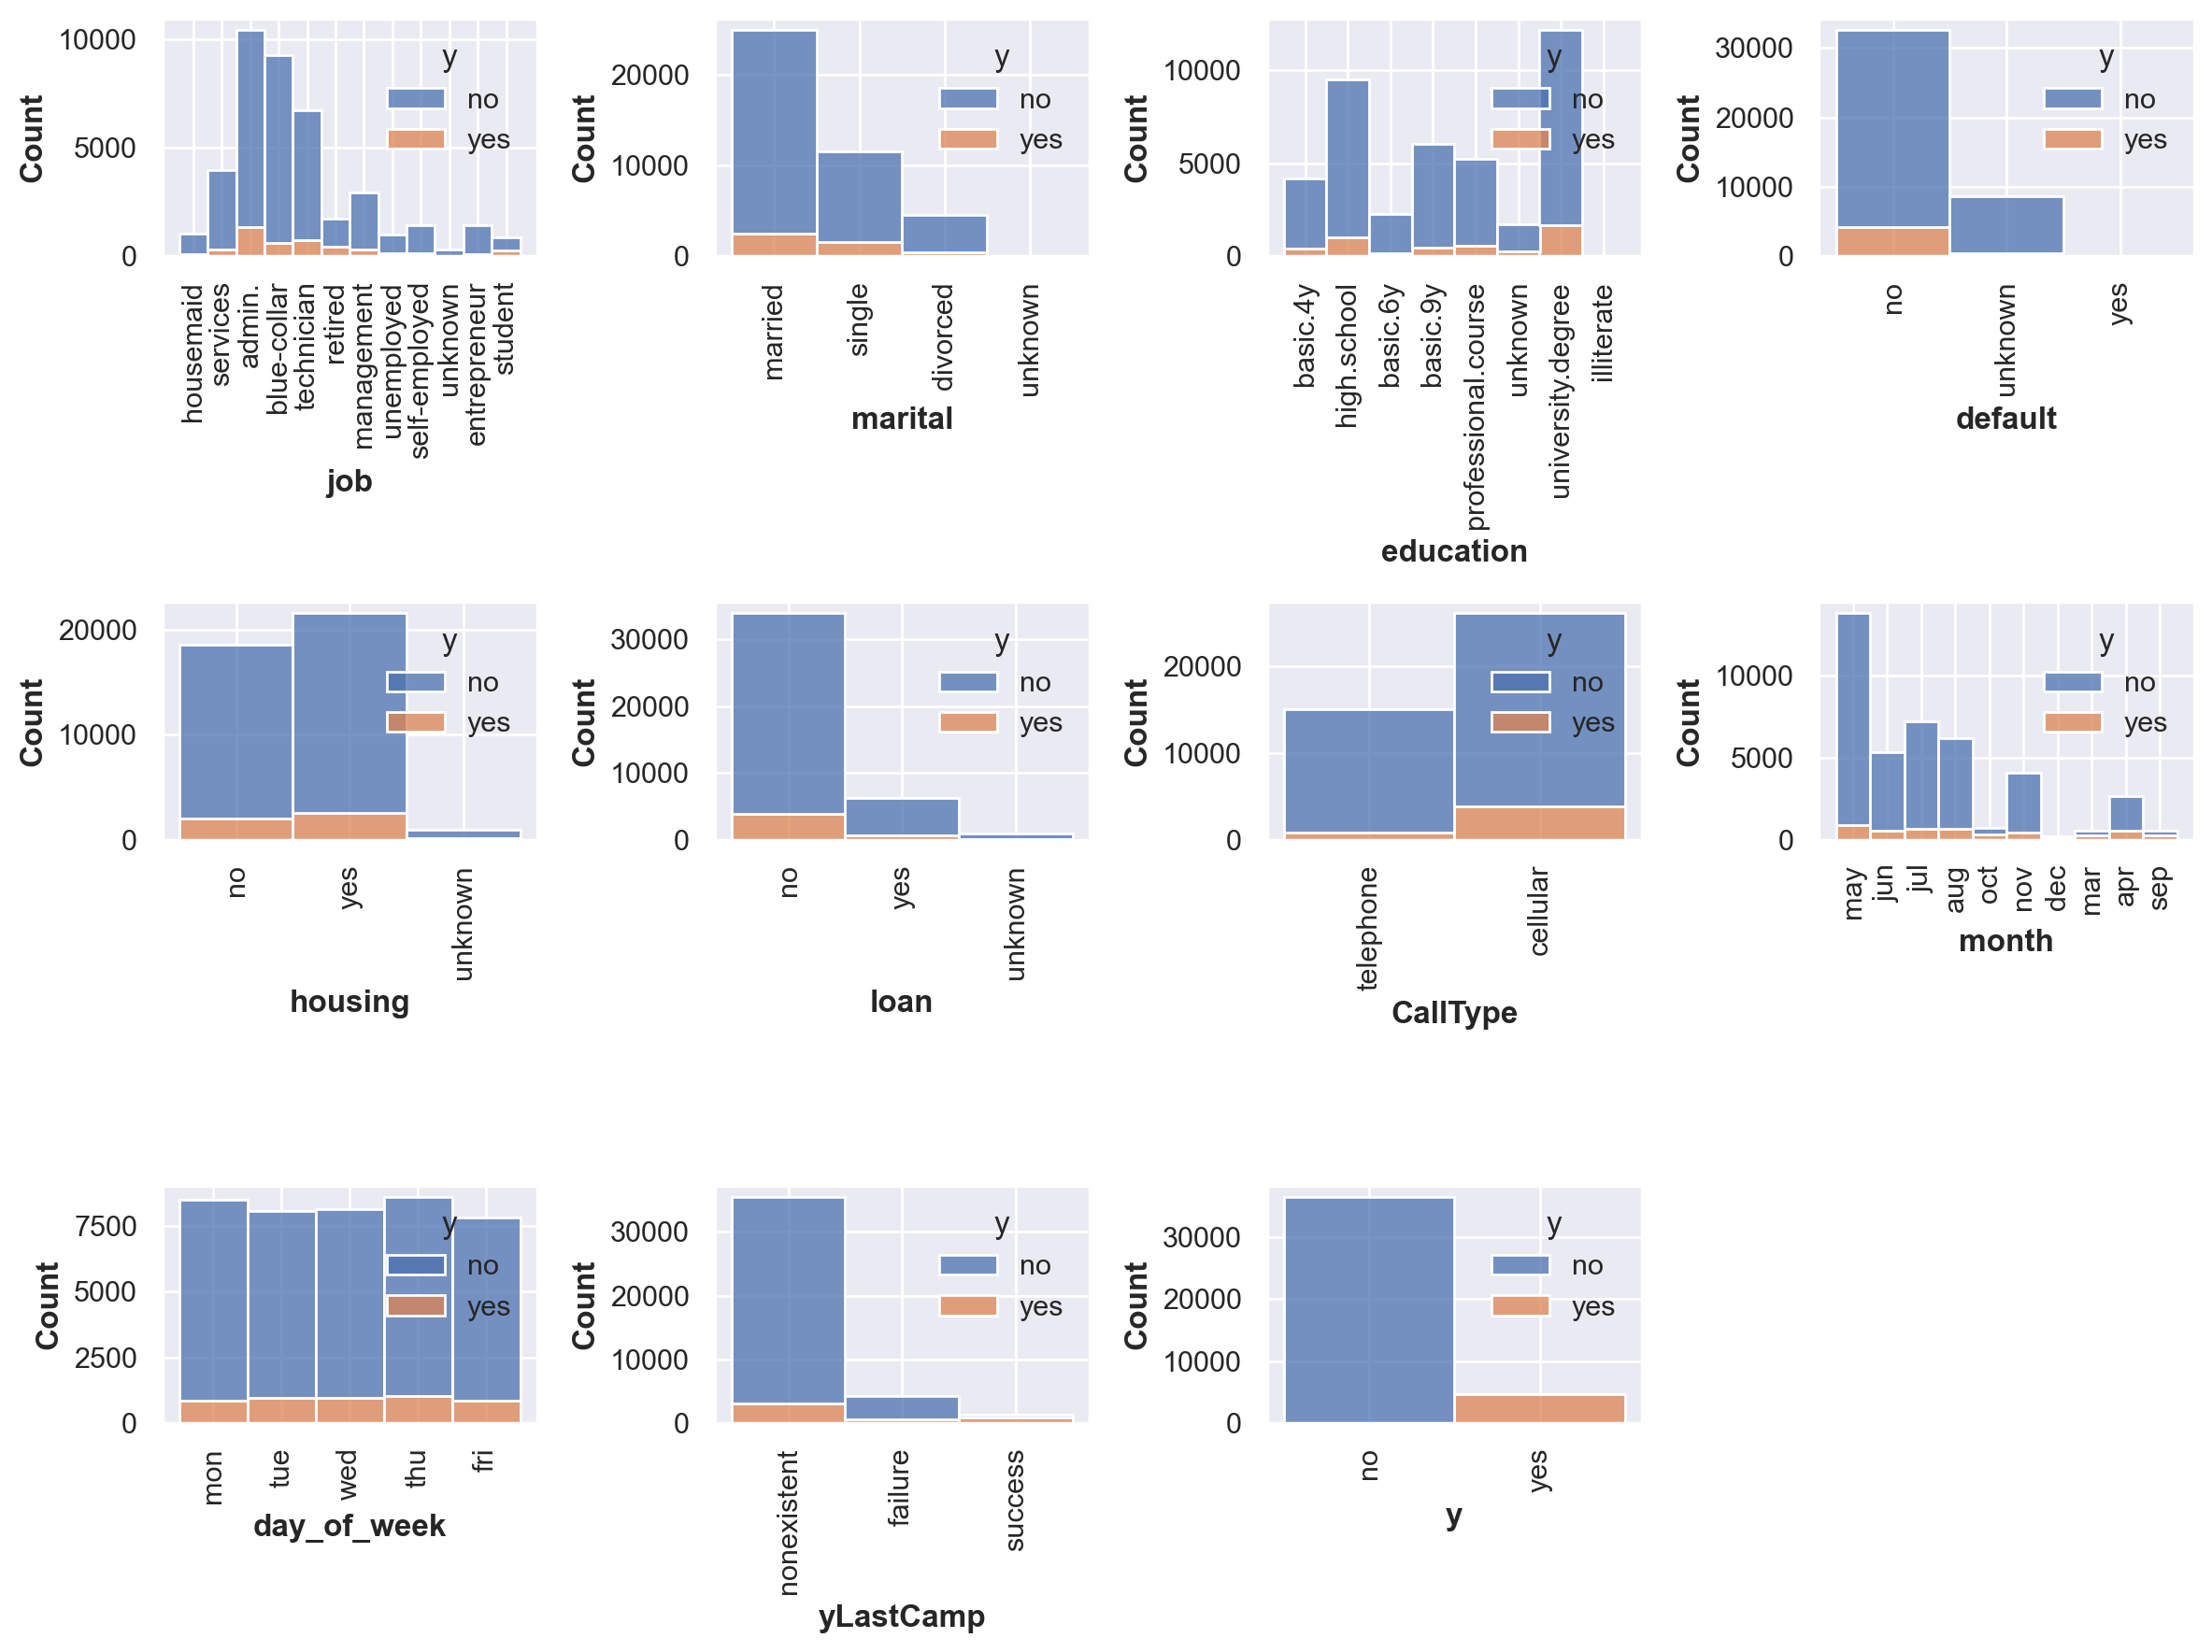

In [213]:
plt.figure(figsize=(12,3*rows))
for idx, ele in enumerate(cat_features, start=1):
    plt.subplot(rows, 4, idx)
    sns.histplot(x=ele, data=df, hue='y', multiple='stack')
    plt.xticks(rotation=90)

Insights:
- Job: the most common job are ‘admin’, 'blue collar', 'technician'.
- Marital: the majority of clients are married.
- Education: most of clients have received university degree and high school education.
- Default: most of clients do not have credit in default.
- Housing: about half of the clients have a housing loan.
- Loan: most of clients do not have a personal loan.
- CallType: the most common communication type is ‘cellular’.
- Month: may is the month with the highest number of last contacts.
- day_of_week: nearly equal number of contact for each weekday.
- yLastCamp: the outcome of the previous campaign is mostly ‘nonexistent’, i.e not contacted.

- 6 Variables having unknown values: 'job','education', 'marital', 'housing', 'default', 'loan'. Let them be for the moment. Can impute them if necessary. 

Insights:
- Usually 'job' of a person is influenced by his 'education' and 'age'. It can be seen that people with management job usually have a tertiary education level. Most of primary educated people have blue color job. Secondary educated people have jobs like services, blue-collar, technician and admin.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'housemaid'),
  Text(1, 0, 'services'),
  Text(2, 0, 'admin.'),
  Text(3, 0, 'blue-collar'),
  Text(4, 0, 'technician'),
  Text(5, 0, 'retired'),
  Text(6, 0, 'management'),
  Text(7, 0, 'unemployed'),
  Text(8, 0, 'self-employed'),
  Text(9, 0, 'unknown'),
  Text(10, 0, 'entrepreneur'),
  Text(11, 0, 'student')])

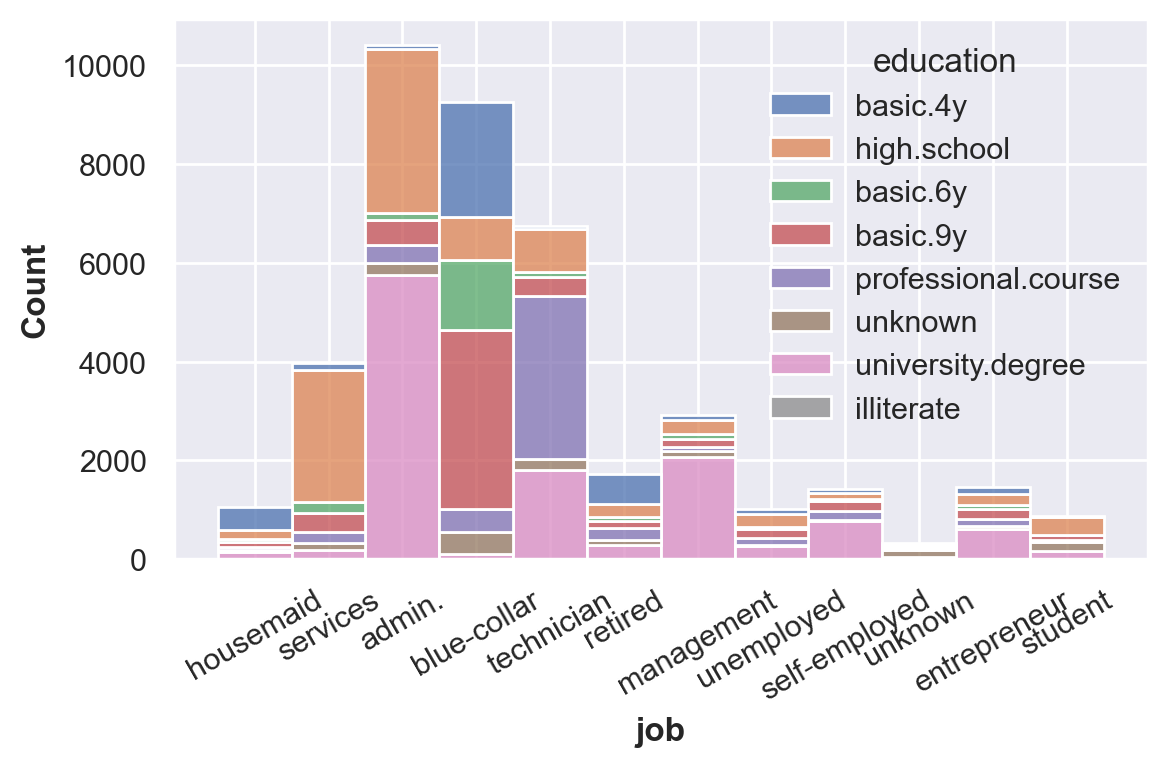

In [8]:
# # Job against education
fig,ax=plt.subplots(figsize=(6,4))
sns.histplot(x='job', data=df, hue='education', multiple='stack')
plt.xticks(rotation=30)

In [214]:
# Relationship bw categorical features and y
# Calculate conversion rate: for example, conversion rate of december = total of 'yes'/total of ('yes'+'no') in december.
# Look at the details for education as an example
conversion_month=df.groupby('education')['y'].value_counts().to_frame(name='count')
conversion_month['Conversion%']=df.groupby('education')['y'].value_counts(normalize=True)
conversion_month

count  Conversion%
education           y                      
basic.4y            no    3748     0.897510
                    yes    428     0.102490
basic.6y            no    2103     0.917940
                    yes    188     0.082060
basic.9y            no    5572     0.921754
                    yes    473     0.078246
high.school         no    8481     0.891611
                    yes   1031     0.108389
illiterate          no      14     0.777778
                    yes      4     0.222222
professional.course no    4645     0.886450
                    yes    595     0.113550
university.degree   no   10495     0.862792
                    yes   1669     0.137208
unknown             no    1479     0.854913
                    yes    251     0.145087

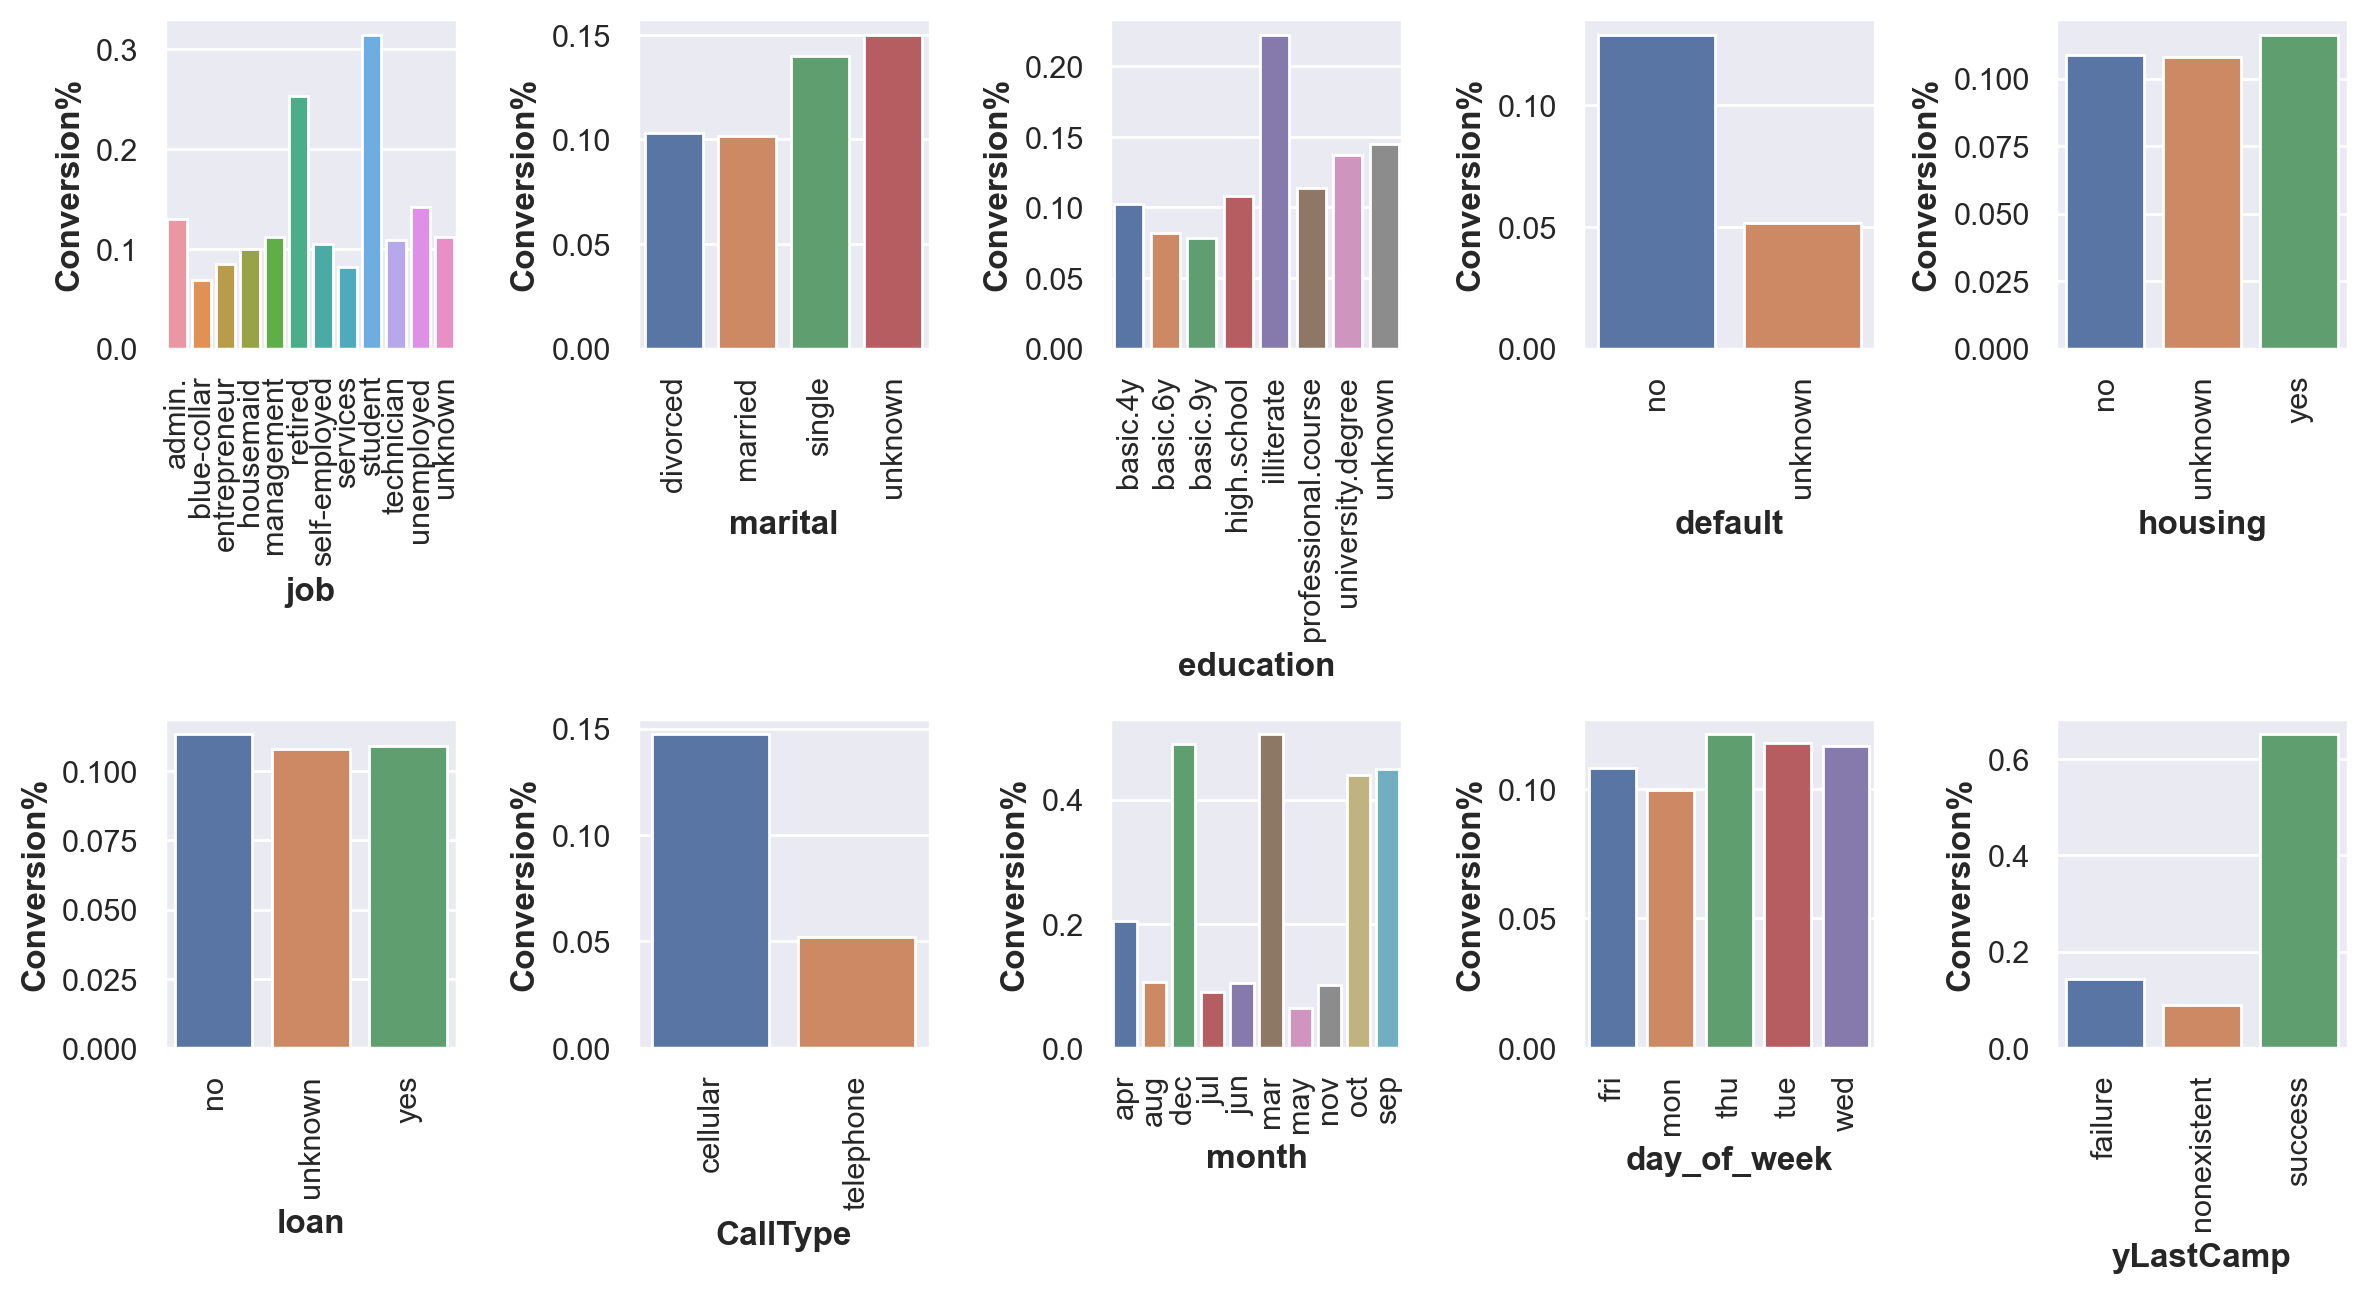

In [215]:
plt.figure(figsize=(12,3*rows))
for idx, ele in enumerate(cat_features[:-1], start=1):
    df_i=df.groupby(ele)['y'].value_counts(normalize=True).to_frame(name='Conversion%')
    df_i_positive=df_i.loc[(slice(None), 'yes'),]
    df_i_positive.reset_index('y', drop=True, inplace=True)
    plt.subplot(rows, 5, idx)
    sns.barplot(df_i_positive,x=df_i_positive.index,  y='Conversion%')
    plt.xticks(rotation=90)

Insights: 
- Highest conversion rate factors (>0.2): for job (retired, student), yLastCamp ('illiterate'), months (april, december, march, september, october), yLastCamp ('success').
- Lowest conversion rate factors (~ 0.05): default credit (unknown), calltype (telephone), month(may).

## IV.2 Explore numerical variables 

In [216]:
df.describe() 

age   duration(s)  nCallThisCamp  nDayPassLastCallLastCamp  \
count  41176.00000  41176.000000   41176.000000              41176.000000   
mean      40.02380    258.315815       2.567879                962.464810   
std       10.42068    259.305321       2.770318                186.937102   
min       17.00000      0.000000       1.000000                  0.000000   
25%       32.00000    102.000000       1.000000                999.000000   
50%       38.00000    180.000000       2.000000                999.000000   
75%       47.00000    319.000000       3.000000                999.000000   
max       98.00000   4918.000000      56.000000                999.000000   

       nCallBefThisCamp  emp.var.rate  cons.price.idx  cons.conf.idx  \
count      41176.000000  41176.000000    41176.000000   41176.000000   
mean           0.173013      0.081922       93.575720     -40.502863   
std            0.494964      1.570883        0.578839       4.627860   
min            0.000000     -3.400000       92.201000     -50.800000   
25%            0.000000     -1.800000       93.075000     -42.700000   
50%            0.000000      1.100000       93.749000     -41.800000   
75%            0.000000      1.400000       93.994000     -36.400000   
max            7.000000      1.400000       94.767000     -26.900000   

          euribor3m   nr.employed  
count  41176.000000  41176.000000  
mean       3.621293   5167.034870  
std        1.734437     72.251364  
min        0.634000   4963.600000  
25%        1.344000   5099.100000  
50%        4.857000   5191.000000  
75%        4.961000   5228.100000  
max        5.045000   5228.100000

In [164]:
for i in num_features[2:]:
    print(df[i].value_counts(), '\n')

1     17634
2     10568
3      5340
4      2650
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: nCallThisCamp, dtype: int64 

999    39661
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: nDayPassLastCallLastCamp, dtype: int64 

0    35551
1     4561
2      754
3      216
4       70
5      

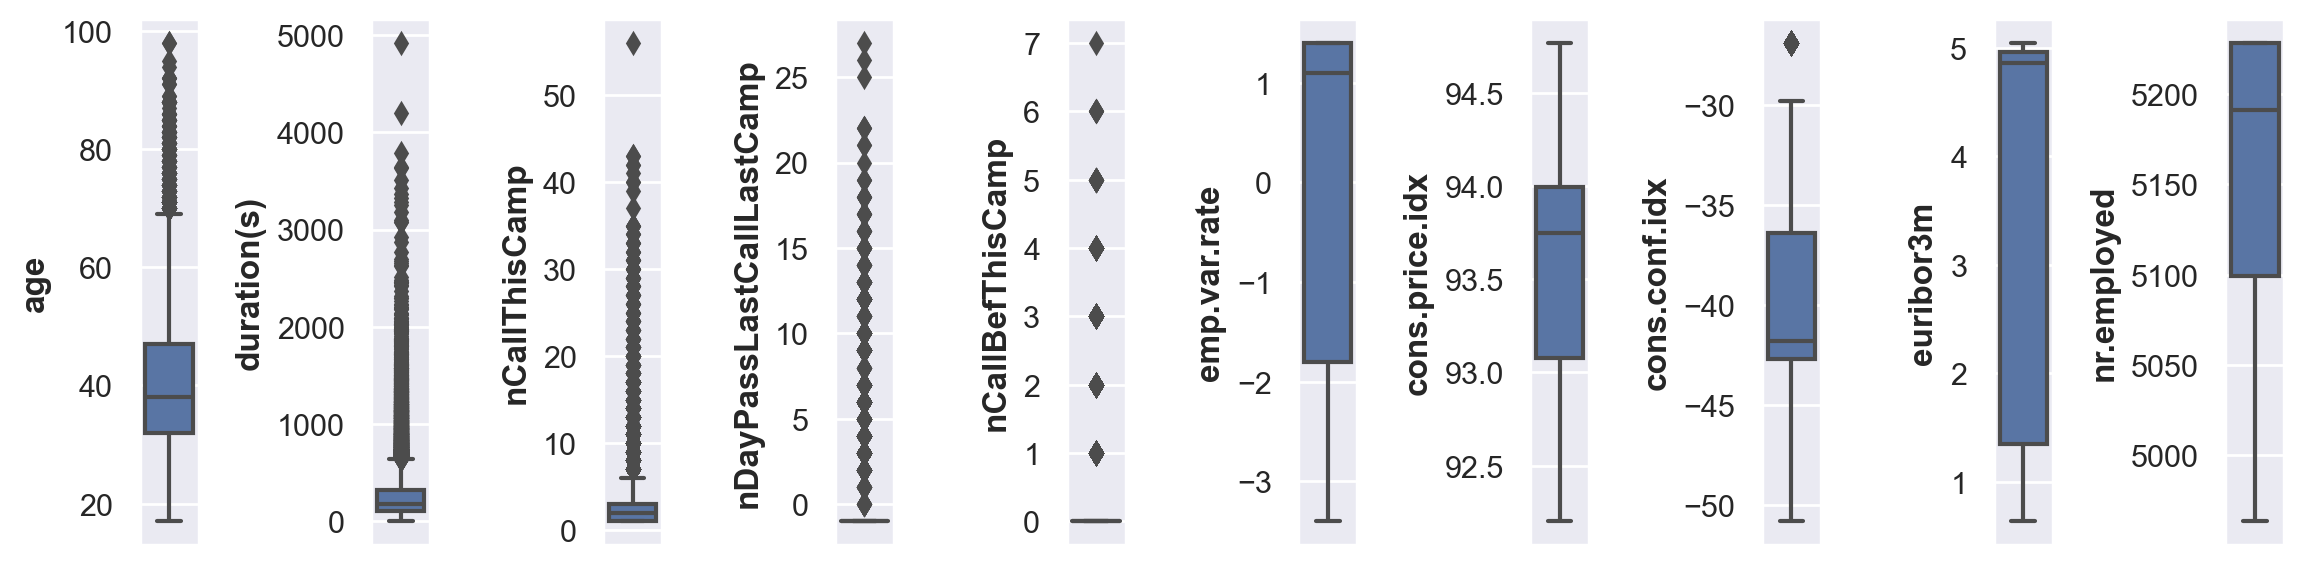

In [223]:
# Plot numerical features
fig=plt.figure(figsize=(14,3))
for idx, ele in enumerate(num_features):
    sns.boxplot(df, y=ele, ax=plt.subplot(1,12,(idx+1)))

Insights:
- Age: clients ages range from 17 to 98, with a mean around 40. There are a few outliers, but the age range seems reasonable.
- Duration: the average duration of the last contact is approximately 4 mins (258 seconds).There are some outliers where the duration of the last contact is unusually long (>1h).
- nCallThisCamp: on average, a client was contacted approximately 3 times during this campaign. Some clients have been contacted a significantly higher number of times during this campaign with max>50.
- nDayPassLassCallLastCamp: most of clients have a value of 999, i.e. not contacted before this campaign. 
- nCallBefThisCamp: many clients have been contacted 0-2 times before this campaign.
- For numerical features balance, duration, nCallThisCamp, nDayPassLassCallLastCamp, nCallBefThisCamp: Mean >> median, have skewness and outliers.
- Numerical features need to be rescaled.

In [6]:
# Replace 999 by -1. (Models without and With replacement were both built. With replacement model performance was better.)
df['nDayPassLastCallLastCamp'].replace(999, -1, inplace=True)

In [14]:
# Check replacement
df['nDayPassLastCallLastCamp'].value_counts()

-1     39661
 3       439
 6       412
 4       118
 9        64
 2        61
 7        60
 12       58
 10       52
 5        46
 13       36
 11       28
 1        26
 15       24
 14       20
 8        18
 0        15
 16       11
 17        8
 18        7
 22        3
 19        3
 21        2
 25        1
 26        1
 27        1
 20        1
Name: nDayPassLastCallLastCamp, dtype: int64

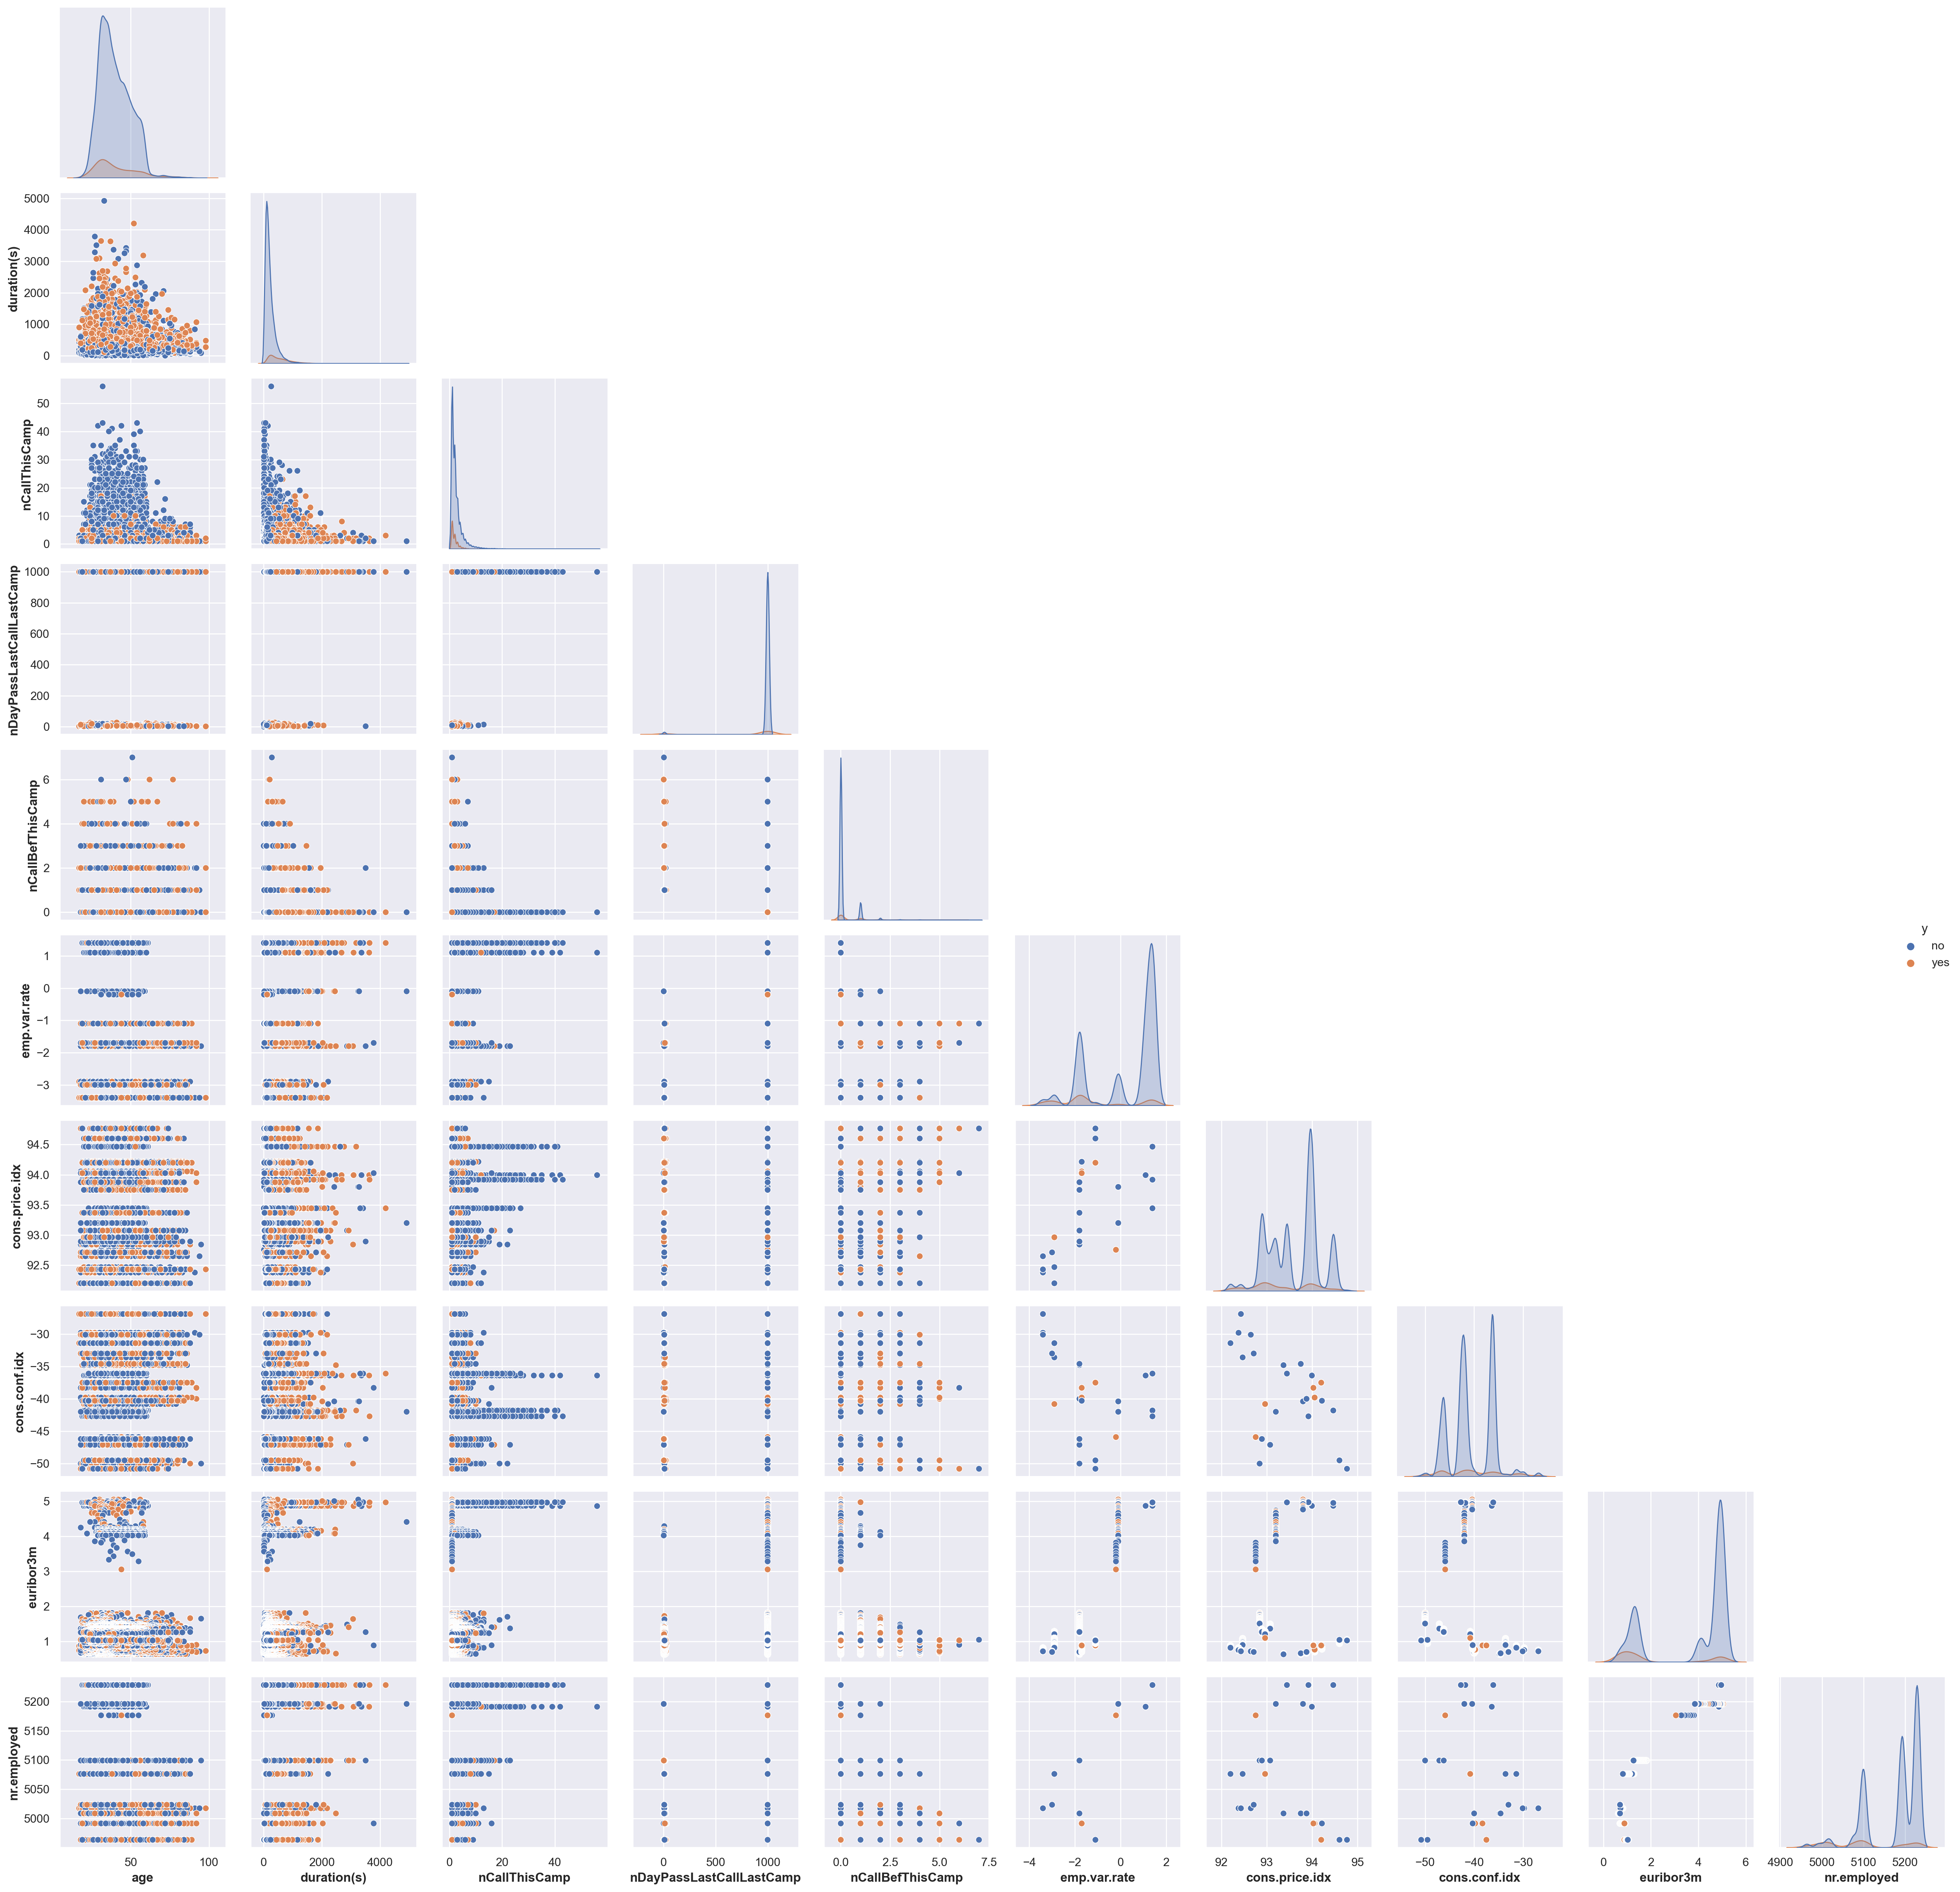

In [147]:
sns.pairplot(pd.concat([df[num_features], df['y']], axis=1), hue='y', corner=True)

Insights: 
- Duration(s) has 2 extreme outliers (df['duration(s)']>4000). This column will be kept in index to avoid data leakage. 
- nCallThisCamp has 1 extreme outlier (df['nCallThisCamp']>50).

## IV.3 Handle 'unknown' values and outliers

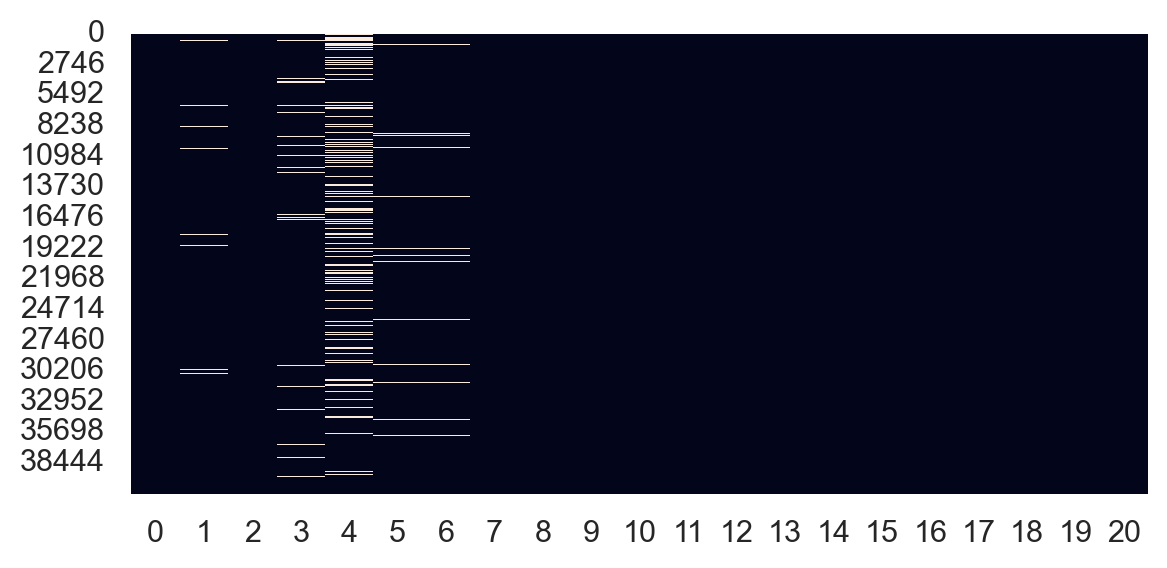

In [148]:
#  Visualize unknown values 
fig=plt.figure(figsize=(6,3))
sns.heatmap(df.values=='unknown', cbar=False)
plt.show()

In [151]:
# Percentage of 'unknown' values:
unknown_cols=['job','education', 'marital','default', 'loan']
unknown_df=pd.DataFrame(index=unknown_cols, columns=['Unknown', 'UnknownRate'])
for i in unknown_cols:
    count=df[df[i].values=='unknown'][i].count()
    rate=count/df.shape[0]
    unknown_df.loc[i]=[count, rate] 
unknown_df

Unknown UnknownRate
job           330    0.008014
education    1730    0.042015
marital        80    0.001943
default      8596    0.208762
loan          990    0.024043

Insights: 
- Default has 21% of unknown values.  We can delete this feature and see how much the results of analysis change. If the change is significant, consider keeping this feature and imputing the missing values.
- The others contain <0.5% unknown values. We can explore some imputation techniques to fill these unknown values. 

In [7]:
# 3 extreme outliers are deleted.
outliers_to_delete=pd.concat([df[df['duration(s)']>4000], df[df['nCallThisCamp']>50]])
df_new=df.drop(index=outliers_to_delete.index)
outliers_to_delete.shape[0], df_new.shape

(3, (41173, 21))

## IV.4 Milticollinearity and mutual information

In [21]:
df_new.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'CallType', 'month', 'day_of_week', 'duration(s)', 'nCallThisCamp',
       'nDayPassLastCallLastCamp', 'nCallBefThisCamp', 'yLastCamp',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')

In [8]:
# Creating dummies 
df1=pd.get_dummies(df_new, drop_first=True,dtype=np.int64)
df1.head()

age  duration(s)  nCallThisCamp  nDayPassLastCallLastCamp  \
0   56          261              1                        -1   
1   57          149              1                        -1   
2   37          226              1                        -1   
3   40          151              1                        -1   
4   56          307              1                        -1   

   nCallBefThisCamp  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0                 0           1.1          93.994          -36.4      4.857   
1                 0           1.1          93.994          -36.4      4.857   
2                 0           1.1          93.994          -36.4      4.857   
3                 0           1.1          93.994          -36.4      4.857   
4                 0           1.1          93.994          -36.4      4.857   

   nr.employed  ...  month_nov  month_oct  month_sep  day_of_week_mon  \
0       5191.0  ...          0          0          0                1   
1       5191.0  ...          0          0          0                1   
2       5191.0  ...          0          0          0                1   
3       5191.0  ...          0          0          0                1   
4       5191.0  ...          0          0          0                1   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  yLastCamp_nonexistent  \
0                0                0                0                      1   
1                0                0                0                      1   
2                0                0                0                      1   
3                0                0                0                      1   
4                0                0                0                      1   

   yLastCamp_success  y_yes  
0                  0      0  
1                  0      0  
2                  0      0  
3                  0      0  
4                  0      0  

[5 rows x 54 columns]

In [9]:
df1.shape

(41173, 54)

In [10]:
y= df1['y_yes']
X=df1.iloc[ : , 0:-1]

In [15]:
X.shape, y.shape

((41173, 53), (41173,))

In [14]:
# VIF (detect co-linearity bw predictors). Note: the inclusion of the constant term (intercept) in the calculation of variance inflation factors (VIFs) is a topic of debate among statisticians. Here the constant is included because the overall model fit is an important consideration.

X_vif=add_constant(X)
  
# Calculate VIF for each feature and store the values in vif_df dataframe
vif_df = pd.DataFrame() 
vif_df['Feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])] 
vif_df['VIF'] = round(vif_df['VIF'], 2)
vif_df = vif_df.sort_values(by = "VIF", ascending = False)
vif_df.head(15)

Feature         VIF
36              loan_unknown         inf
34           housing_unknown         inf
0                      const  6021033.58
6               emp.var.rate      238.47
10               nr.employed      200.05
9                  euribor3m      198.65
7             cons.price.idx       89.67
4   nDayPassLastCallLastCamp       12.44
53         yLastCamp_success       11.14
39                 month_aug       10.55
42                 month_jun        9.16
8              cons.conf.idx        6.82
44                 month_may        6.20
5           nCallBefThisCamp        5.95
52     yLastCamp_nonexistent        5.13

In [16]:
high_vif_features=vif_df['Feature'][:7]
list(high_vif_features)

['loan_unknown',
 'housing_unknown',
 'const',
 'emp.var.rate',
 'nr.employed',
 'euribor3m',
 'cons.price.idx']

In [18]:
# Linear correlation bw predictors and y
corr = df1.corr()['y_yes'].to_frame()

In [19]:
# First 15 highest correlation bw predictors and y
corr['abs']=abs(corr['y_yes'])
corr.sort_values('abs', ascending=False)[:15]

y_yes       abs
y_yes                     1.000000  1.000000
duration(s)               0.407205  0.407205
nr.employed              -0.354760  0.354760
nDayPassLastCallLastCamp -0.324990  0.324990
yLastCamp_success         0.316343  0.316343
euribor3m                -0.307818  0.307818
emp.var.rate             -0.298375  0.298375
nCallBefThisCamp          0.230243  0.230243
yLastCamp_nonexistent    -0.193563  0.193563
CallType_telephone       -0.144865  0.144865
month_mar                 0.144048  0.144048
month_oct                 0.137559  0.137559
cons.price.idx           -0.136133  0.136133
month_sep                 0.126097  0.126097
month_may                -0.108238  0.108238

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

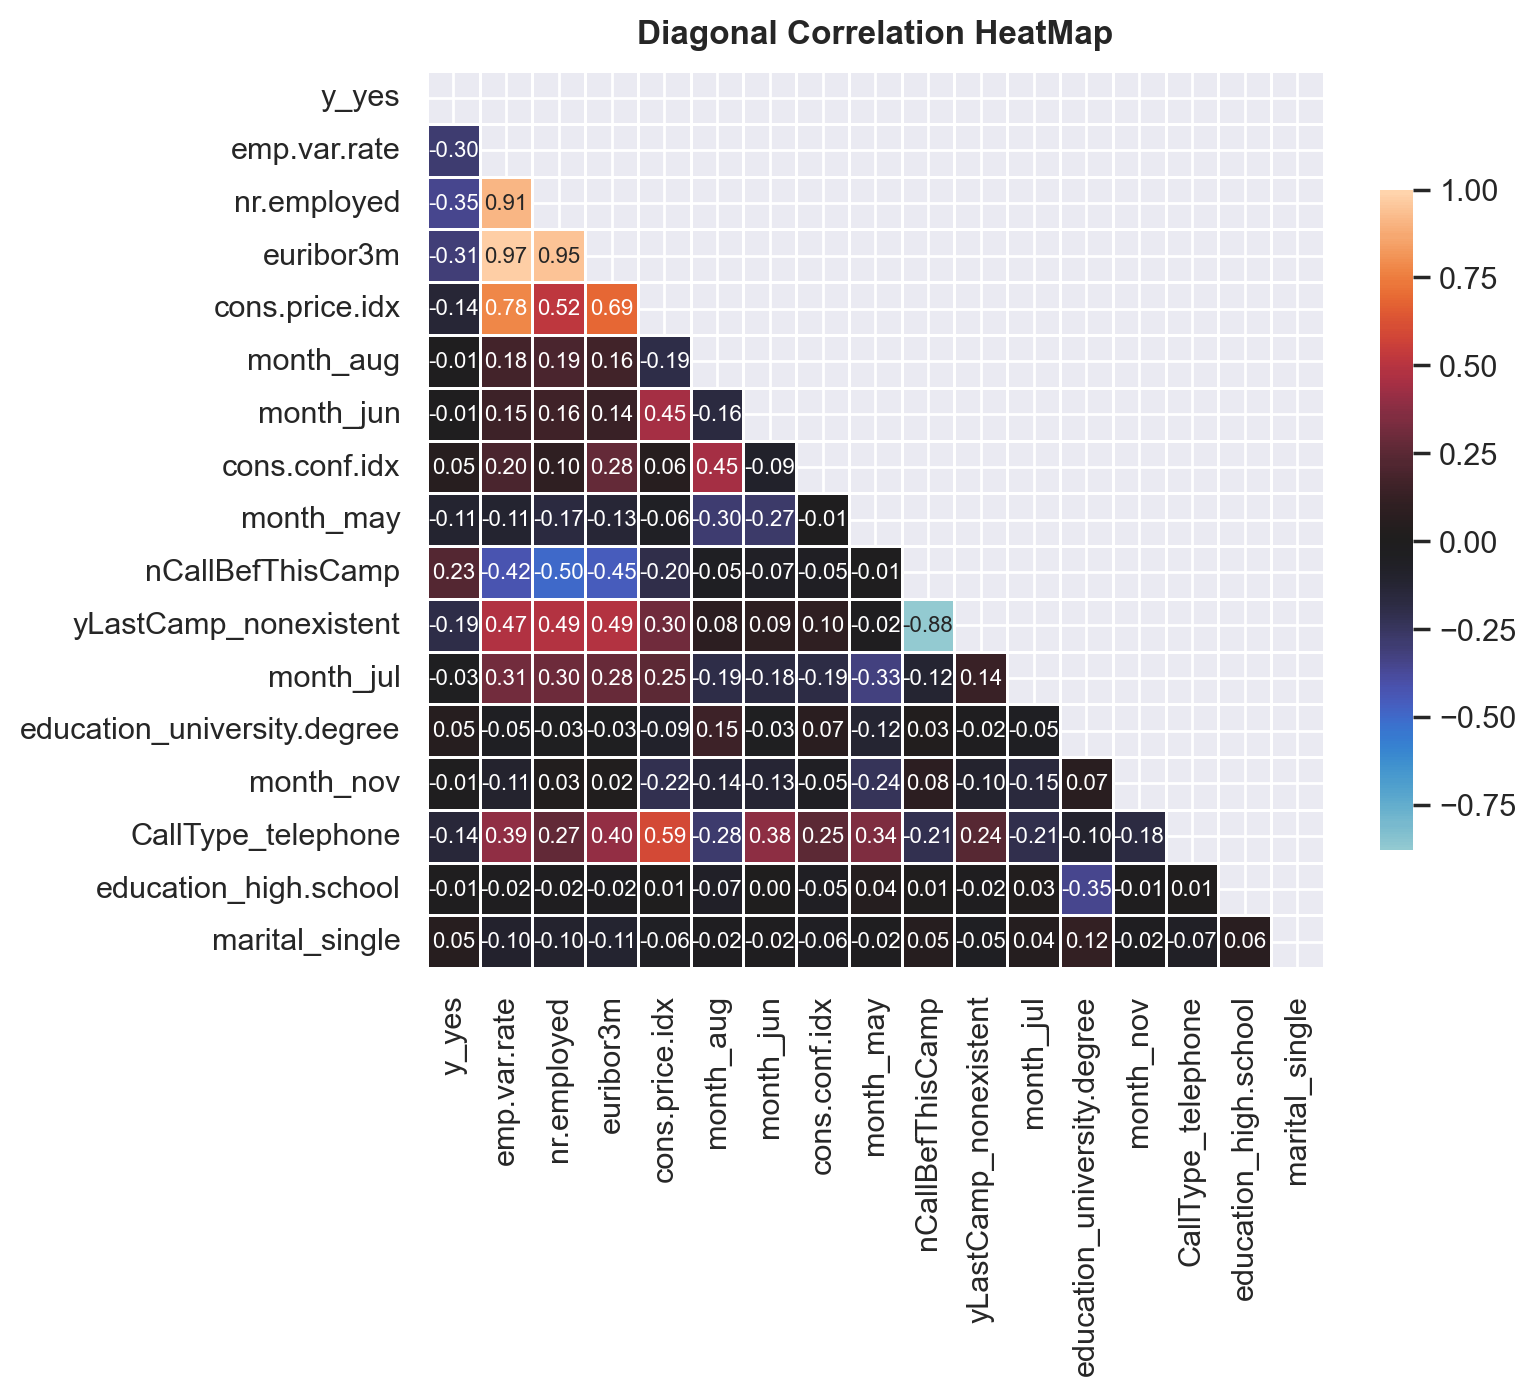

In [145]:
#  Chose some features to visualize correlation by heatmap 
fig, ax = plt.subplots(figsize=(8, 8))
X_to_corr=['y_yes']+list(vif_df.Feature[3:19])
corr1 = df1[X_to_corr].corr()
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr1, mask=mask,vmax=1, center=0, annot=True, fmt='.2f', square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={'size':8})
plt.title("Diagonal Correlation HeatMap")

Insights:
- 9 features have high VIF values, >10. 
<!-- Removing these 6 features do not help to improve model performance in model training (had tried)-->
-  'nDayPassLastCallLastCamp' has high negative correlation with 'yLastCamp_nonexistent' (r=0.88), since customers not contacted have unknown response. 
- 'job_management' and 'education_tertiary' are intermediately positively correlated, as observed in prior analysis.

In [80]:
# Mutual information (detect linear and non-linear relationship) between X and y
discrete_features = X.dtypes == 'int64'

In [78]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [81]:
mi_scores = make_mi_scores(X=X, y=y, discrete_features=discrete_features)
mi_scores[:20]  # show the first 20 MI scores

duration(s)                 0.097397
euribor3m                   0.073070
cons.conf.idx               0.070243
cons.price.idx              0.068907
nr.employed                 0.066861
emp.var.rate                0.056873
nDayPassLastCallLastCamp    0.031556
yLastCamp_success           0.028990
nCallBefThisCamp            0.019279
yLastCamp_nonexistent       0.015010
age                         0.014141
CallType_telephone          0.011662
month_may                   0.006378
month_mar                   0.006369
month_oct                   0.006097
default_unknown             0.005762
month_sep                   0.005075
job_retired                 0.003340
nCallThisCamp               0.003334
job_student                 0.003191
Name: MI Scores, dtype: float64

In [77]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

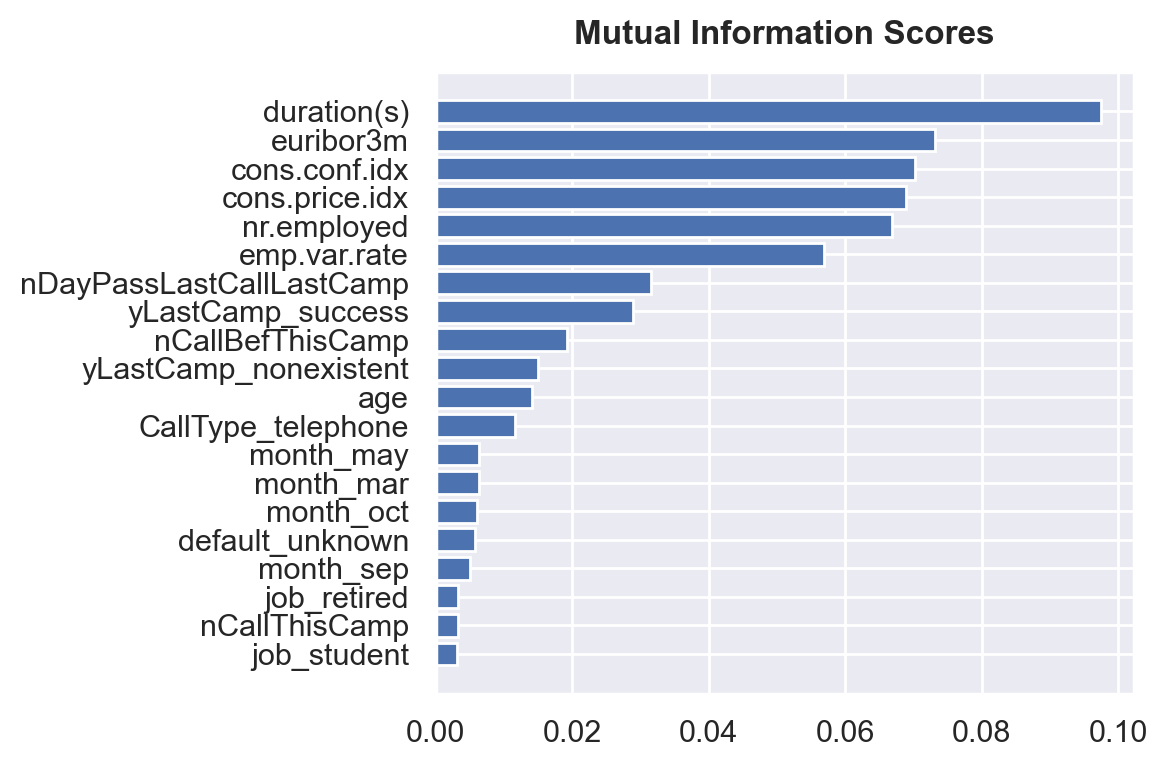

In [82]:
plt.figure(dpi=100, figsize=(6, 4))
plot_mi_scores(mi_scores[:20])

Insights:
- Mutual information showed that euribor3m has strongest relationship with response y. Correlation matrix showed euribor3m are highly correlated to nr.employed and emp.var.rate. Therefore, nr.employed and emp.var.rate can be considered as redundant features. They can be deleted. 
- Top 6 features which have highest linear relationship with y: duration(s), nDayPassLastCallLastCamp, yLastCamp_success,
euribor3m, nCallBefThisCamp, yLastCamp_nonexistent.
- Top 7 features which have highest mutual information score with y: duration(s), euribor3m, cons.conf.idx, cons.price.idx, nDayPassLastCallLastCamp, yLastCamp_success, nCallBefThisCamp.


## IV.5 PCA analysis

In [ ]:
features_pca1=['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
features_pca2=['nCallThisCamp','nDayPassLastCallLastCamp','nCallBefThisCamp',]

In [ ]:
def pca_eng (features_pca):
    scaler=StandardScaler()
    features_pca_scaled= pd.DataFrame(scaler.fit_transform(X_train[features_pca]), columns=features_pca)

    pca=PCA()
    pca.fit(features_pca_scaled)

    fig, axes = plt.subplots(1, 2, figsize = (8,4))
    plt.title('Variance Explained by PC')
    ticks = np.arange(pca.n_components_)+1  # num of array+1 i.e total num of PCA 4

    ax = axes[0]
    ax.plot(ticks, pca.explained_variance_ratio_, marker='o', linestyle='-', color='r')
    ax.set_xlabel('Principle component')
    ax.set_ylabel('Prop of var explained')
    ax.set_ylim ([0,1])
    ax.set_xticks(ticks)
    ax.grid(True)

    ax = axes[1]  # cumsum() 
    ax.plot(ticks, pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='-', color='r')
    ax.set_xlabel('Principle component')
    ax.set_ylabel('Cumulative prop of var explained')
    ax.set_ylim([0,1])
    ax.set_xticks(ticks)
    ax.grid(True)

    component_names = [f"PC{k+1}" for k in range(len(features_pca))]
    loadings = pd.DataFrame(pca.components_.T, columns=component_names, index=features_pca)
    # transpose the matrix of loadings so the columns are the principal component and the rows are the original features
                            
    X_pca = pca.transform(features_pca_scaled)
    X_pca = pd.DataFrame(X_pca, columns=component_names, index=X_train.index)
    # Convert to dataframe

    mi_scores = make_mi_scores(X=X_pca, y=y_train, discrete_features=False)
    
    return features_pca_scaled, fig, loadings, X_pca, mi_scores

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed
0     -1.197964       -1.179278      -1.230647  -1.336661    -0.935366
1      0.838935        0.590528      -0.474966   0.773609     0.844099
2      0.838935        0.590528      -0.474966   0.772457     0.844099
3      0.647976        0.721753       0.885260   0.713118     0.332330
4      0.838935       -0.227899       0.950033   0.774762     0.844099 

 Figure(800x400) 

                      PC1       PC2       PC3       PC4       PC5
emp.var.rate   -0.532113 -0.047961 -0.011396  0.793360 -0.291558
cons.price.idx -0.419719 -0.199611  0.820658 -0.317725 -0.097788
cons.conf.idx  -0.132524  0.972852  0.126140 -0.072920 -0.121523
euribor3m      -0.530067  0.050420 -0.180520 -0.051746  0.825361
nr.employed    -0.492096 -0.094190 -0.527154 -0.511504 -0.457648 

                         PC1       PC2       PC3       PC4       PC5
      duration(s)                                                  
32943 146          2.46

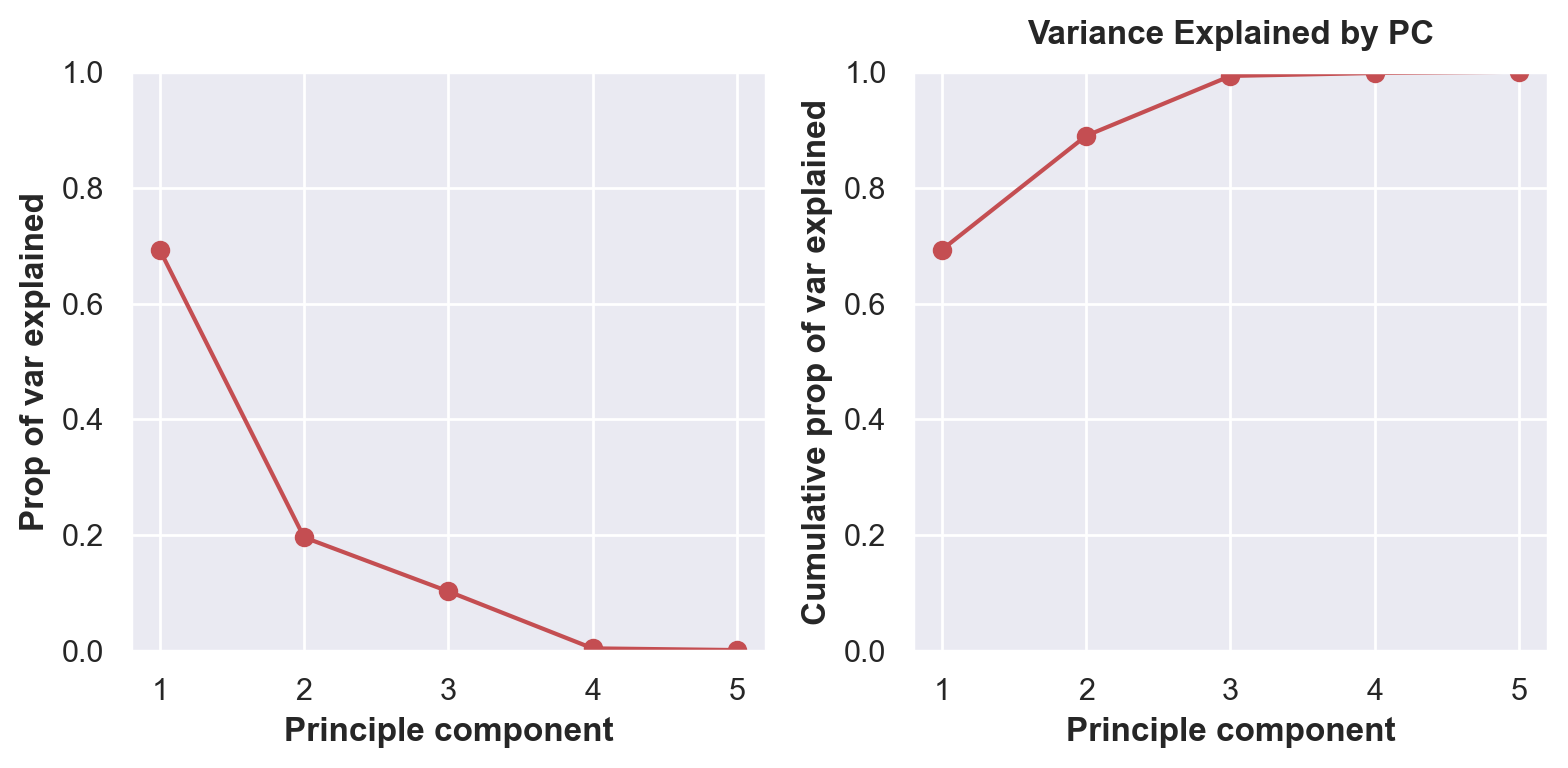

In [179]:
features_pca_scaled_1, fig_1, loadings_1, X_pca_1, mi_scores_1 = pca_eng (features_pca1)
print(f'{features_pca_scaled_1.head()} \n\n {fig_1} \n\n {loadings_1} \n\n {X_pca_1.head()} \n\n {mi_scores_1}')

   nCallThisCamp  nDayPassLastCallLastCamp  nCallBefThisCamp
0      -0.205253                 -0.171792         -0.349452
1      -0.205253                 -0.171792         -0.349452
2      -0.205253                 -0.171792         -0.349452
3      -0.205253                 -0.171792         -0.349452
4       0.154555                 -0.171792         -0.349452 

 Figure(800x400) 

                                PC1       PC2       PC3
nCallThisCamp            -0.165849  0.984814 -0.051346
nDayPassLastCallLastCamp  0.694373  0.153591  0.703033
nCallBefThisCamp          0.700243  0.080945 -0.709301 

                         PC1       PC2       PC3
      duration(s)                              
32943 146         -0.329948 -0.256808  0.137630
17583 76          -0.329948 -0.256808  0.137630
15948 482         -0.329948 -0.256808  0.137630
395   769         -0.329948 -0.256808  0.137630
21912 588         -0.389622  0.097535  0.119155 

 PC3    0.035594
PC2    0.033306
PC1    0.033249
Na

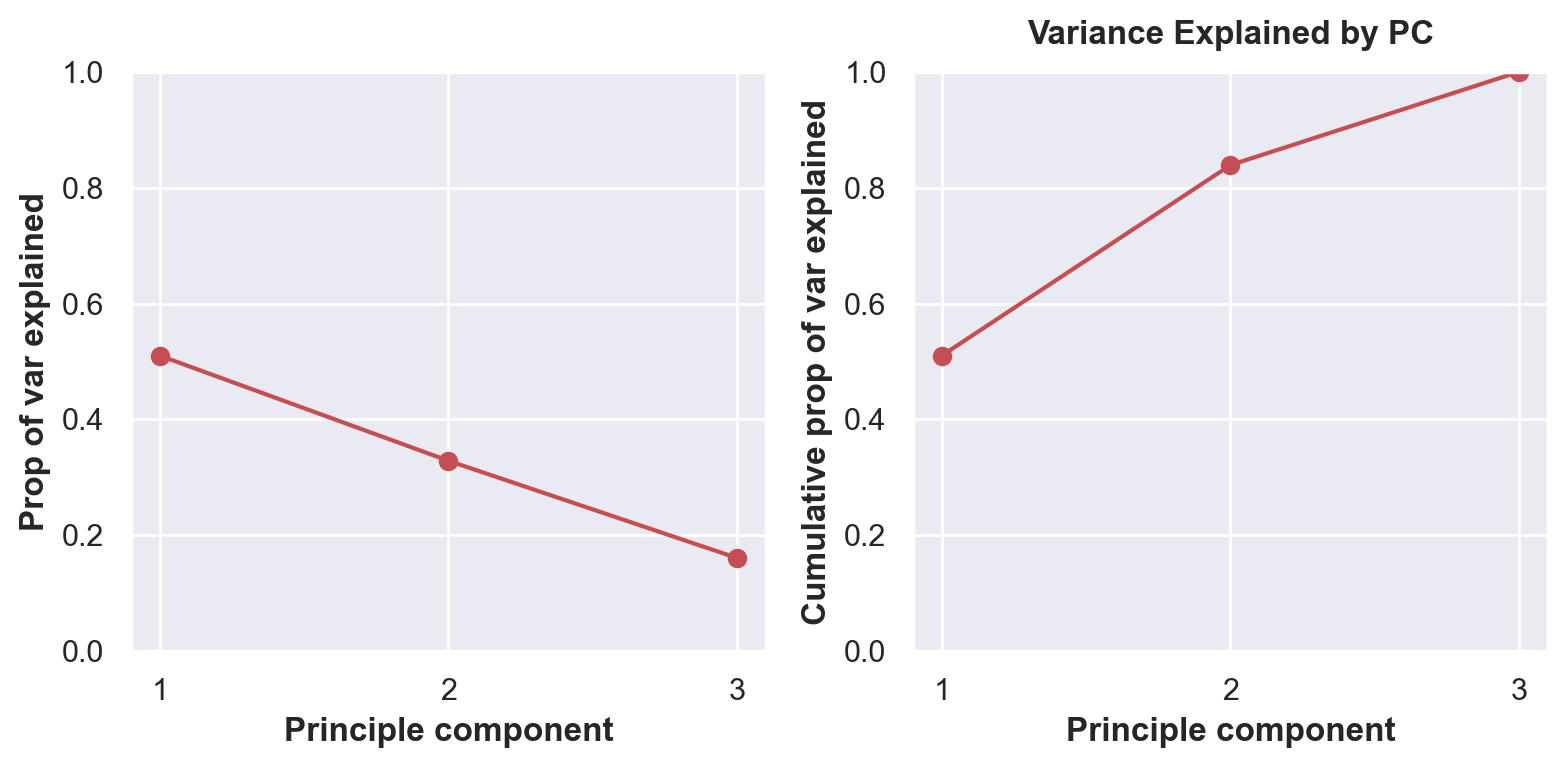

In [180]:
features_pca_scaled_2, fig_2, loadings_2, X_pca_2, mi_scores_2 = pca_eng (features_pca2)
print(f'{features_pca_scaled_2.head()} \n\n {fig_2} \n\n {loadings_2} \n\n {X_pca_2.head()} \n\n {mi_scores_2}')

Insights:
- The goal  of PCA analysis on numeric features is to use the results of PCA to discover one or more new features that can improve the performance of the model. One option is to create features inspired by the loadings. Another option is to use the components themselves as features (that is, add one or more columns of X_pca to X). Based on mi_scores on X_pca, no component has particular potential. We will still join all of X_pca to X.

# V Model training

- Any redundant variable is dropped. Let model do the selection and see.
- After separating X and y, we do a train test stratified split with shuffle.
- Accuracy is not the preferred performance metric for skewed datasets. We have only 11% positive responses. If we always guess that a client will not registered, we will be right about 89% of the time, i.e accuracy of random guess is 89% and precision of random guess is 11%. This is our benchmark. 
- We concern about the precision TP/(TP+FP)(accuracy of positive prediction) and recall TP/(TP+FN) (true positive rate, ratio of positive instances that are correctly detected). However, the importance of precision vs. recall  depends on the specific goals of the campaign. Therefore, we inspect a set of metrics: accuracy, precision, recall, roc_auc, auc of precision recall curve and cohen_kappa for each model. After training, we select the appropriate model based on the goals of campaign.
- We will train different kinds of individual models and ensemble models, using original data, PCA components, as well as balanced data produced by oversampling the minority class.

## V.1 Visualization with T-SNE 

In [11]:
XToModel=X.set_index ('duration(s)', append=True)

In [12]:
XToModel.shape

(41173, 52)

In [13]:
X_train, X_test, y_train, y_test= train_test_split(XToModel, y, test_size=0.3, random_state=42, stratify=y)

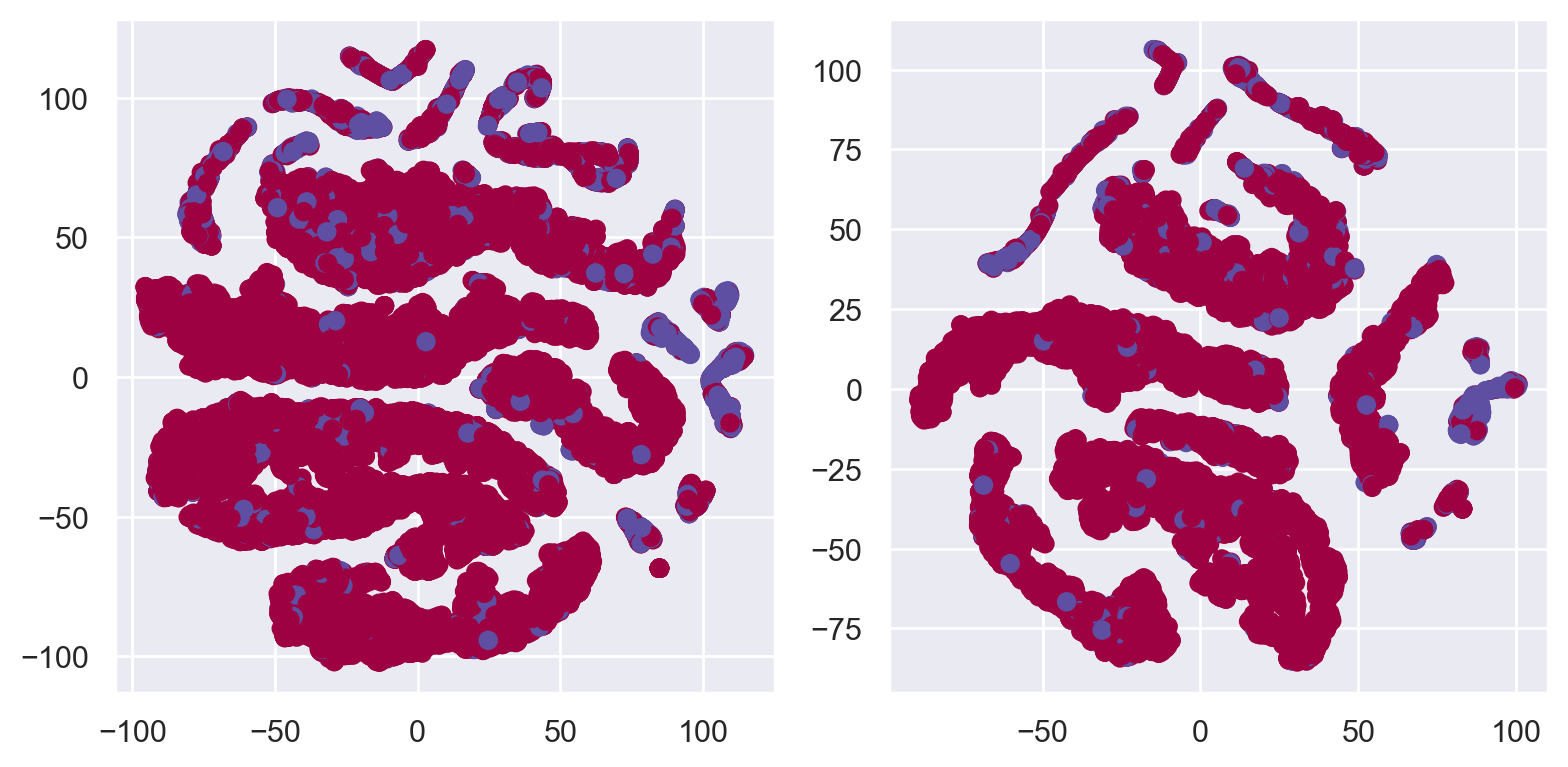

In [24]:
# T-SNE plot for train and test data  t-distributed stochastic neighbor embedding (t-SNE) 
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca')
tsne_train = tsne.fit_transform(X_train) 
tsne_test = tsne.fit_transform(X_test) 

fig=plt.figure(figsize=(8, 4))
ax1=plt.subplot(1,2,1)
ax1=plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=y_train.values, cmap=plt.cm.Spectral)
ax2=plt.subplot(1,2,2)
ax2=plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=y_test.values, cmap=plt.cm.Spectral)

Insights: 
- It is clear that the two classes are highly overlapping, without a visible separation between classes.

## V.2 Models trained with original X_train

In [46]:
# Note that regularization L2 is applied by default in LogisticRegression; use default parameters for all models
skfolds=StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

models=[LogisticRegression(penalty='l2',C=1.0), 
        GaussianNB(),
        KNeighborsClassifier(n_neighbors=5),
        SGDClassifier(), 
        LDA(),
        QDA(),
        SVC(kernel='linear', C=1.0), 
        SVC(kernel='rbf'),
        RandomForestClassifier(random_state=42), 
        GradientBoostingClassifier(learning_rate=0.5, random_state=42), 
        XGBClassifier(learning_rate=0.01, random_state=42,objective='binary:logistic'),
        CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=False),
        #loss_function='CrossEntropy'
        MLPClassifier(hidden_layer_sizes=(50,50), random_state=42)
        ]

# Score functions report scores for class 1 by default.
def model_performance (model, X, y):
    y_pred=cross_val_predict(model, X, y, cv=skfolds, method='predict')
    accuracy=accuracy_score (y, y_pred)
    precision=precision_score(y, y_pred)
    recall=recall_score(y, y_pred)
    f1=f1_score(y, y_pred)
    roc_auc=roc_auc_score(y, y_pred)
    pr_auc=average_precision_score(y, y_pred)
    kappa=cohen_kappa_score(y, y_pred)
    return {'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1':f1, 'roc_auc': roc_auc, 'pr_auc':pr_auc, 'kappa': kappa}

In [27]:
# Compare various individual models
performance_origin=pd.DataFrame()
for model in models:
    pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                                ['classifier', model]])
    performance = pd.DataFrame(model_performance(pipeline, X_train, y_train), index=[f'{model}'[:20]])
    performance_origin=pd.concat([performance, performance_origin], axis=0)
performance_origin.sort_values('pr_auc', ascending=False)

accuracy  precision    recall        f1   roc_auc  \
LinearDiscriminantAn  0.890254   0.518041  0.371420  0.432646  0.663774   
<catboost.core.CatBo  0.901218   0.661290  0.252541  0.365500  0.618059   
GradientBoostingClas  0.897783   0.601347  0.275023  0.377430  0.625937   
RandomForestClassifi  0.895215   0.567680  0.293194  0.386677  0.632422   
LogisticRegression()  0.899865   0.659031  0.230366  0.341397  0.607617   
SGDClassifier()       0.895875   0.595645  0.235910  0.337966  0.607788   
SVC()                 0.897922   0.638763  0.216200  0.323056  0.600338   
KNeighborsClassifier  0.889803   0.521793  0.261780  0.348646  0.615660   
SVC(kernel='linear')  0.897262   0.638566  0.202957  0.308016  0.594186   
GaussianNB()          0.730093   0.248166  0.687712  0.364720  0.711593   
MLPClassifier(hidden  0.864855   0.377273  0.306745  0.338373  0.621230   
XGBClassifier(base_s  0.896222   0.750000  0.118263  0.204310  0.556629   
QuadraticDiscriminan  0.140835   0.115020  0.989837  0.206092  0.511439   

                        pr_auc     kappa  
LinearDiscriminantAn  0.263227  0.373719  
<catboost.core.CatBo  0.251212  0.323367  
GradientBoostingClas  0.247061  0.330058  
RandomForestClassifi  0.246070  0.335699  
LogisticRegression()  0.238526  0.300577  
SGDClassifier()       0.226602  0.292757  
SVC()                 0.226404  0.282154  
KNeighborsClassifier  0.219763  0.295623  
SVC(kernel='linear')  0.219397  0.268251  
GaussianNB()          0.205850  0.238663  
MLPClassifier(hidden  0.193829  0.264004  
XGBClassifier(base_s  0.188035  0.179117  
QuadraticDiscriminan  0.114996  0.005296

In [28]:
# Try voting classifier
vcf=VotingClassifier(estimators=[('LDA', LDA()),
                                ('CAT', CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=False)),
                                ('GBC', GradientBoostingClassifier(learning_rate=0.5, random_state=42)), 
                                ('RFC', RandomForestClassifier(random_state=42)),
                                ('LGC', LogisticRegression(penalty='l2',C=1.0))],
                    voting='soft')

In [29]:
pipeline_voting = Pipeline(steps = [['scaler', StandardScaler()], ['classifier', vcf]])
pipeline_voting.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ['classifier',
                 VotingClassifier(estimators=[('LDA',
                                               LinearDiscriminantAnalysis()),
                                              ('CAT',
                                               <catboost.core.CatBoostClassifier object at 0x0000022843383A10>),
                                              ('GBC',
                                               GradientBoostingClassifier(learning_rate=0.5,
                                                                          random_state=42)),
                                              ('RFC',
                                               RandomForestClassifier(random_state=42)),
                                              ('LGC', LogisticRegression())],
                                  voting='soft')]])

In [30]:
performance_voting = pd.DataFrame(model_performance(pipeline_voting, X_train, y_train), index=['voting'])
performance_voting

accuracy  precision    recall        f1   roc_auc    pr_auc     kappa
voting  0.900489   0.627096  0.287958  0.394681  0.633109  0.260797  0.348485

In [33]:
## Try LDA ensemble classifier
ensemble_LDA=EasyEnsembleClassifier(random_state=42, n_estimators=100, estimator= LDA())
performance_ensemble=pd.DataFrame()
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                                ['classifier', ensemble_LDA]])
performance_ensemble_LDA = pd.DataFrame(model_performance(pipeline, X_train, y_train), index=[f'{ensemble_LDA}'[:20]])
performance_ensemble_LDA

accuracy  precision    recall        f1   roc_auc  \
EasyEnsembleClassifi  0.821172   0.339721  0.622421  0.439539  0.734414   

                        pr_auc     kappa  
EasyEnsembleClassifi  0.253988  0.343904

Insights:
- 13 different individual classifiers are build. 
- The best 5 individual classifiers are combined to give a voting model. Compared with individual models, the voting model does not display a significant improvement in performance. 
- The best individual model LDA is aggregated in a ensemble model, resulting in greatly improved recall and roc_auc score, however,  accuracy, pr_auc and kappa score are decreased. 

We conclude: 
- The best precision model: XGBClassifier 
- The best recall model: GaussianNB (QDA is not considered since accuracy is 14% and recall is 0.98, almost equals to random guess.)
- The best balance between precision and recall and prioritize precision: LDA
- The best balance between precision and recall and prioritize precision: ensemble_LDA

In [50]:
Best_models=performance_origin.loc[['XGBClassifier(base_s','GaussianNB()','LinearDiscriminantAn']]
Best_models=pd.concat([Best_models, performance_ensemble_LDA], axis=0)
Best_models

accuracy  precision    recall        f1   roc_auc  \
XGBClassifier(base_s  0.896222   0.750000  0.118263  0.204310  0.556629   
GaussianNB()          0.730093   0.248166  0.687712  0.364720  0.711593   
LinearDiscriminantAn  0.890254   0.518041  0.371420  0.432646  0.663774   
EasyEnsembleClassifi  0.821172   0.339721  0.622421  0.439539  0.734414   

                        pr_auc     kappa  
XGBClassifier(base_s  0.188035  0.179117  
GaussianNB()          0.205850  0.238663  
LinearDiscriminantAn  0.263227  0.373719  
EasyEnsembleClassifi  0.253988  0.343904

## V.3 Models trained by adding PCA components

In [ ]:
X_train_pca=pd.concat([X_train, X_pca_1, X_pca_2], axis=1)
X_train_pca.shape

(28821, 60)

In [ ]:
performance_pca=pd.DataFrame()
for model in models:
    pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                                ['classifier', model]])
    performance = pd.DataFrame(model_performance(pipeline, X_train_pca, y_train), index=[f'{model}'[:20]])
    performance_pca=pd.concat([performance, performance_pca], axis=0)
performance_pca.sort_values('pr_auc', ascending=False)

accuracy  precision    recall        f1   roc_auc  \
LinearDiscriminantAn  0.889560   0.513594  0.372344  0.431709  0.663786   
<catboost.core.CatBo  0.901426   0.661882  0.255621  0.368807  0.619521   
RandomForestClassifi  0.893515   0.550282  0.299969  0.388280  0.634422   
GradientBoostingClas  0.896048   0.581759  0.275023  0.373484  0.624960   
SVC()                 0.898685   0.638912  0.231598  0.339964  0.607490   
LogisticRegression()  0.898997   0.650808  0.223283  0.332493  0.604036   
KNeighborsClassifier  0.890982   0.529779  0.287650  0.372854  0.627617   
GaussianNB()          0.769543   0.276615  0.647367  0.387608  0.716211   
SVC(kernel='linear')  0.897262   0.647423  0.193409  0.297842  0.590018   
MLPClassifier(hidden  0.863710   0.376137  0.318448  0.344897  0.625694   
XGBClassifier(base_s  0.896707   0.749077  0.125038  0.214305  0.559860   
SGDClassifier()       0.892231   0.581692  0.154604  0.244282  0.570244   
QuadraticDiscriminan  0.271052   0.125401  0.915614  0.220590  0.552415   

                        pr_auc     kappa  
LinearDiscriminantAn  0.261946  0.372263  
<catboost.core.CatBo  0.253053  0.326529  
RandomForestClassifi  0.243934  0.335453  
GradientBoostingClas  0.241674  0.324637  
SVC()                 0.234540  0.297874  
LogisticRegression()  0.232820  0.291726  
KNeighborsClassifier  0.232645  0.318846  
GaussianNB()          0.218800  0.272809  
SVC(kernel='linear')  0.216089  0.259461  
MLPClassifier(hidden  0.196564  0.269425  
XGBClassifier(base_s  0.192237  0.188137  
SGDClassifier()       0.185175  0.206752  
QuadraticDiscriminan  0.124326  0.027949

Insights: 
- Adding pca components into the features can not improve model performance.

## V.4 Models trained with SMOTE-ENN over-sampling

In [40]:
# Synthetic Minority Oversampling TEchnique + Nearest Neighbor (ENN)
performance_smote_enn=pd.DataFrame()
for model in models:
    pipeline = Pipeline(steps = [['smote', SMOTEENN(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', model]])
    performance = pd.DataFrame(model_performance(pipeline, X_train, y_train), index=[f'{model}'[:20]])
    performance_smote_enn=pd.concat([performance, performance_smote_enn], axis=0)
performance_smote_enn.sort_values('pr_auc', ascending=False)


accuracy  precision    recall        f1   roc_auc  \
RandomForestClassifi  0.831165   0.352845  0.597783  0.443759  0.729289   
GradientBoostingClas  0.825579   0.341862  0.592547  0.433577  0.723856   
SVC()                 0.821831   0.333568  0.582692  0.424263  0.717443   
<catboost.core.CatBo  0.807918   0.317900  0.615337  0.419219  0.723853   
SVC(kernel='linear')  0.806634   0.309719  0.583000  0.404530  0.709014   
LogisticRegression()  0.798550   0.299105  0.586695  0.396215  0.706072   
SGDClassifier()       0.796398   0.293655  0.574376  0.388623  0.699482   
MLPClassifier(hidden  0.778564   0.272397  0.577764  0.370239  0.690911   
KNeighborsClassifier  0.767704   0.260556  0.577764  0.359146  0.684792   
LinearDiscriminantAn  0.800562   0.282711  0.501078  0.361475  0.669832   
GaussianNB()          0.756289   0.252198  0.591931  0.353699  0.684544   
XGBClassifier(base_s  0.693869   0.225374  0.704650  0.341518  0.698575   
QuadraticDiscriminan  0.636064   0.191777  0.693871  0.300500  0.661298   

                        pr_auc     kappa  
RandomForestClassifi  0.256239  0.351935  
GradientBoostingClas  0.248473  0.339152  
SVC()                 0.241382  0.327965  
<catboost.core.CatBo  0.238952  0.317878  
SVC(kernel='linear')  0.227545  0.301789  
LogisticRegression()  0.222047  0.290300  
SGDClassifier()       0.216619  0.281497  
MLPClassifier(hidden  0.204951  0.256369  
KNeighborsClassifier  0.198109  0.241333  
LinearDiscriminantAn  0.197869  0.254017  
GaussianNB()          0.195257  0.232419  
XGBClassifier(base_s  0.192084  0.205960  
QuadraticDiscriminan  0.167558  0.150545

In [41]:
# Try voting classifier
vcf_smote=VotingClassifier(estimators=[('RFC', RandomForestClassifier(random_state=42)),
                                ('GBC', GradientBoostingClassifier(learning_rate=0.5, random_state=42)),
                                ('SVC_r', SVC(kernel='rbf')), 
                                ('CBC', CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=False)),
                                ('SVC_l', SVC(kernel='linear', C=1.0))],
                    voting='soft')

In [42]:
pipeline_voting_smote = Pipeline(steps = [['smote', SMOTEENN(random_state=42)],
                                          ['scaler', StandardScaler()],
                                          ['classifier', vcf]])
pipeline_voting_smote.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTEENN(random_state=42)),
                ('scaler', StandardScaler()),
                ['classifier',
                 VotingClassifier(estimators=[('LDA',
                                               LinearDiscriminantAnalysis()),
                                              ('CAT',
                                               <catboost.core.CatBoostClassifier object at 0x0000022843383A10>),
                                              ('GBC',
                                               GradientBoostingClassifier(learning_rate=0.5,
                                                                          random_state=42)),
                                              ('RFC',
                                               RandomForestClassifier(random_state=42)),
                                              ('LGC', LogisticRegression())],
                                  voting='soft')]])

In [43]:
performance_voting_smote = pd.DataFrame(model_performance(pipeline_voting_smote, X_train, y_train), index=['voting_smote'])
performance_voting_smote

accuracy  precision    recall        f1   roc_auc    pr_auc  \
voting_smote  0.822942    0.33844  0.598706  0.432432  0.725059  0.247836   

                 kappa  
voting_smote  0.336993

In [44]:
## Try voting+ensemble classifier
ensemble_smote_RFC=EasyEnsembleClassifier(random_state=42, n_estimators=100, estimator= RandomForestClassifier(random_state=42))
# performance_ensemble_smote_RFC=pd.DataFrame()
pipeline_ensemble_smote_RFC = Pipeline(steps = [['smote', SMOTEENN(random_state=42)],
                            ['scaler', StandardScaler()],
                            ['classifier', ensemble_smote_RFC]])
performance_ensemble_smote_RFC = pd.DataFrame(model_performance(pipeline_ensemble_smote_RFC, X_train, y_train), index=['ensemble_smote_RFC'])
performance_ensemble_smote_RFC

accuracy  precision    recall        f1   roc_auc  \
ensemble_smote_RFC  0.847993   0.384427  0.580844  0.462652  0.731378   

                      pr_auc     kappa  
ensemble_smote_RFC  0.270515  0.378367

Insights:
- The best model after SmoteENN technique is RandomForestClassifier which displays a balance between precision and recall and prioritize recall. 
- Compared with the same kind of model found without smote technique (EasyEnsembleClassifi), only slight improvement is obtained.
- Together with the 4 models found above, in total 5 models are listed in the following table. 
- We can select suitable model according to the specific goals of the campaign and fin turn the model.

In [51]:
Best_models=pd.concat([Best_models, performance_smote_enn.loc[['RandomForestClassifi']]], axis=0)
Best_models.rename(index={'RandomForestClassifi': 'RandomForestClassifi_smote'}, inplace=True)
Best_models

accuracy  precision    recall        f1   roc_auc  \
XGBClassifier(base_s        0.896222   0.750000  0.118263  0.204310  0.556629   
GaussianNB()                0.730093   0.248166  0.687712  0.364720  0.711593   
LinearDiscriminantAn        0.890254   0.518041  0.371420  0.432646  0.663774   
EasyEnsembleClassifi        0.821172   0.339721  0.622421  0.439539  0.734414   
RandomForestClassifi_smote  0.831165   0.352845  0.597783  0.443759  0.729289   

                              pr_auc     kappa  
XGBClassifier(base_s        0.188035  0.179117  
GaussianNB()                0.205850  0.238663  
LinearDiscriminantAn        0.263227  0.373719  
EasyEnsembleClassifi        0.253988  0.343904  
RandomForestClassifi_smote  0.256239  0.351935

## V.5 Performance evaluation

In [137]:
# V.5.1 Delete 3 features with high VIF 
# Can try RFE feature selection here.
X_train2=X_train.drop(['nr.employed','emp.var.rate', 'cons.price.idx'], axis=1)

In [138]:
X_train2.shape

(28821, 49)

In [15]:
pipeline_LDA= Pipeline(steps = [['scaler', StandardScaler()],
                            ['classifier', LDA()]])

In [139]:
# Model is not improved
performance_LDA_train2 = pd.DataFrame(model_performance(pipeline_LDA, X_train2, y_train), index=['LDA_train2'])
performance_LDA_train2

accuracy  precision    recall        f1  roc_auc    pr_auc  \
LDA_train2  0.891572   0.531154  0.320296  0.399616   0.6422  0.246703   

               kappa  
LDA_train2  0.344014

In [ ]:
# V.5.2 Change shreshold
y_prob=cross_val_predict(pipeline_LDA, X_train, y_train, cv=skfolds, method='predict_proba')
y_prob_class1=y_prob[:,1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob_class1)
fpr, tpr, thresholds = roc_curve(y_train, y_prob_class1)

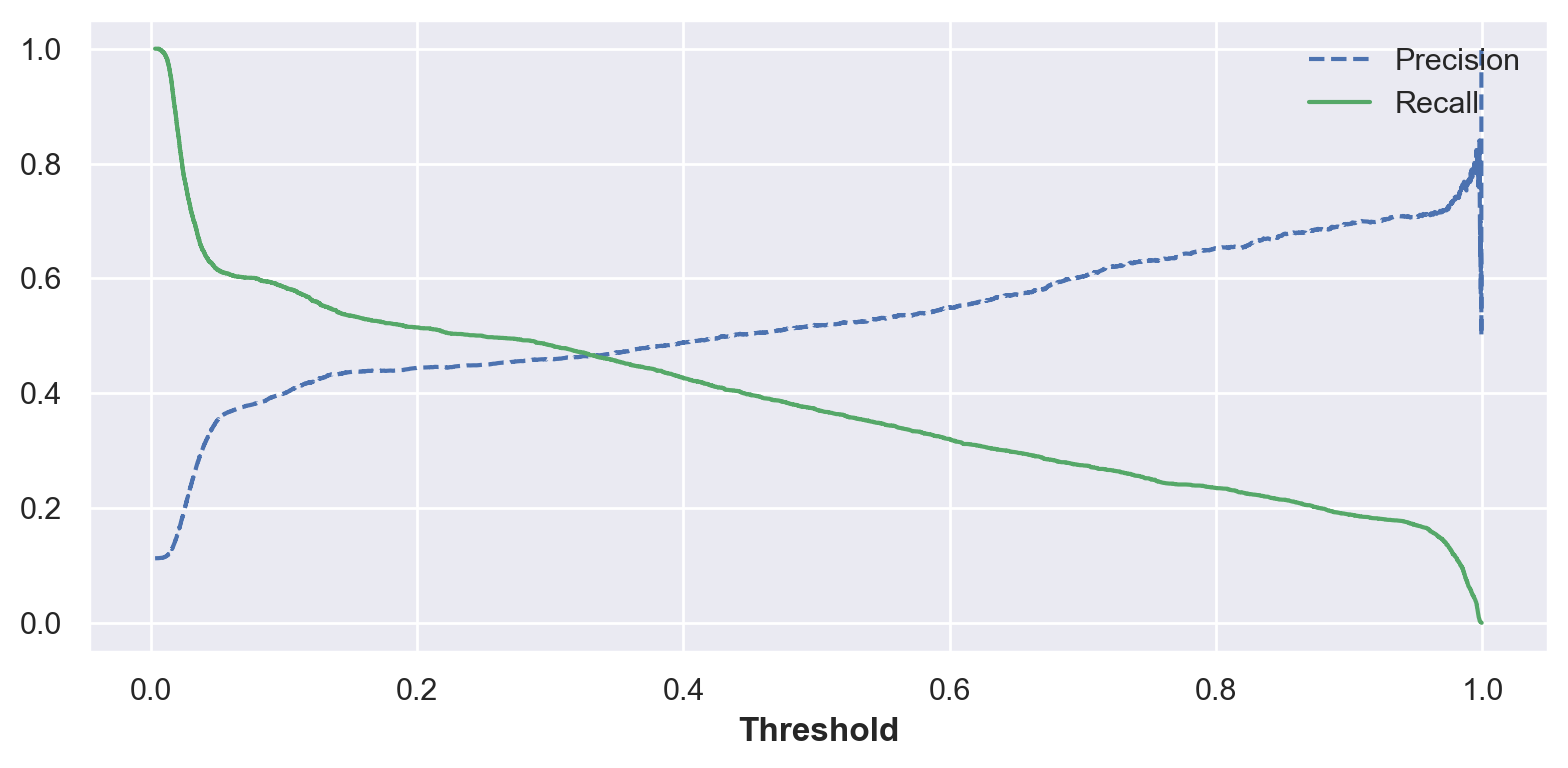

In [126]:
# Makes some plots to visualize precision and recall tradeoff
def plot_precision_recall_vs_threshold (precisions, recalls, thresholds):
    fig=plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper right')

plot_precision_recall_vs_threshold (precisions, recalls, thresholds)

In [57]:
# True positive rate = recall = sensitivity
# False positive rate = 1-TNR = 1-specificity
def precision_recall_auc_plot (model_name, fpr, tpr, recall, precision):
    fig=plt.figure(figsize=(8,4))
    ax1=plt.subplot(1,2,1)
    ax1.plot(fpr, tpr)
    ax1.plot([0,1],[0,1], 'k--')
    plt.ylabel('TPR (recall)')
    plt.xlabel('FPR (1-precision)')
    plt.title('ROC_AUC')
    plt.legend([model_name], loc='upper left')

    ax2=plt.subplot(1,2,2)
    ax2.plot(recall, precision)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision versus recall')
    plt.legend([model_name], loc='upper right')
    return ax1,ax2

(<Axes: title={'center': 'ROC_AUC'}, xlabel='FPR (1-precision)', ylabel='TPR (recall)'>,
 <Axes: title={'center': 'Precision versus recall'}, xlabel='Recall', ylabel='Precision'>)

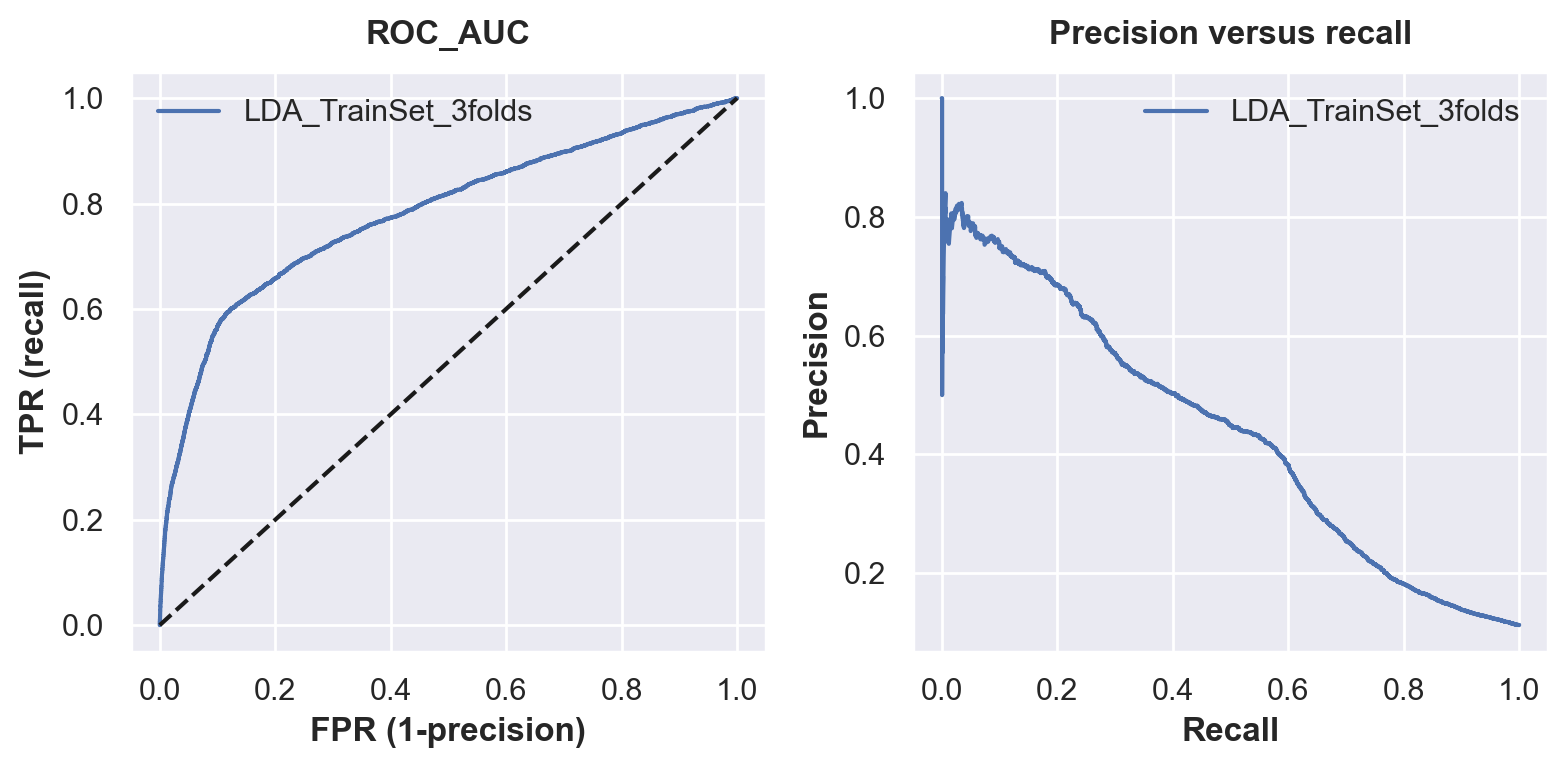

In [58]:
precision_recall_auc_plot ('LDA_TrainSet_3folds', fpr, tpr, recall, precision)

In [ ]:
# The best threshold is 0.1 with maximum F1 and roc_auc
for thresh in range(10):
    thresh = thresh / 10
    print(f'thresh: {thresh} | F1_score: {f1_score(y_train, [1 if x>=thresh else 0 for x in y_prob_class1]):.3f} | roc_auc :{roc_auc_score(y_train, [1 if x>=thresh else 0 for x in y_prob_class1]):.3f}')

thresh: 0.0 | F1_score: 0.203 | roc_auc :0.500
thresh: 0.1 | F1_score: 0.475 | roc_auc :0.737
thresh: 0.2 | F1_score: 0.477 | roc_auc :0.716
thresh: 0.3 | F1_score: 0.471 | roc_auc :0.706
thresh: 0.4 | F1_score: 0.455 | roc_auc :0.685
thresh: 0.5 | F1_score: 0.433 | roc_auc :0.664
thresh: 0.6 | F1_score: 0.405 | roc_auc :0.643
thresh: 0.7 | F1_score: 0.377 | roc_auc :0.626
thresh: 0.8 | F1_score: 0.345 | roc_auc :0.610
thresh: 0.9 | F1_score: 0.297 | roc_auc :0.589


In [16]:
# Train a model with full train data and apply threshold 0.1
LDA_final=pipeline_LDA.fit(X_train, y_train)

In [146]:
# Performance on train set
y_train_prob=LDA_final.predict_proba(X_train)[:,1]
y_train_pred=[1 if i>=0.1 else 0 for i in y_train_prob]

print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

[[22718  2856]
 [ 1340  1907]]
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     25574
           1       0.40      0.59      0.48      3247

    accuracy                           0.85     28821
   macro avg       0.67      0.74      0.70     28821
weighted avg       0.88      0.85      0.87     28821



In [147]:
# Performance on test set
y_test_prob=LDA_final.predict_proba(X_test)[:,1]
y_test_pred=[1 if i>=0.1 else 0 for i in y_test_prob]

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[9775 1186]
 [ 538  853]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     10961
           1       0.42      0.61      0.50      1391

    accuracy                           0.86     12352
   macro avg       0.68      0.75      0.71     12352
weighted avg       0.89      0.86      0.87     12352



Insights:
- Model performs similarly on train data and test data.

## V.6 Model interpretation

In [20]:
explainer= shap.Explainer(pipeline_LDA['classifier'], pipeline_LDA['scaler'].fit_transform(X_train), feature_names=X_train.columns.tolist())

In [21]:
shap_values=explainer.shap_values(pipeline_LDA['scaler'].transform(X_test.iloc[0:1000, : ]))
shap_values.shape

(1000, 52)

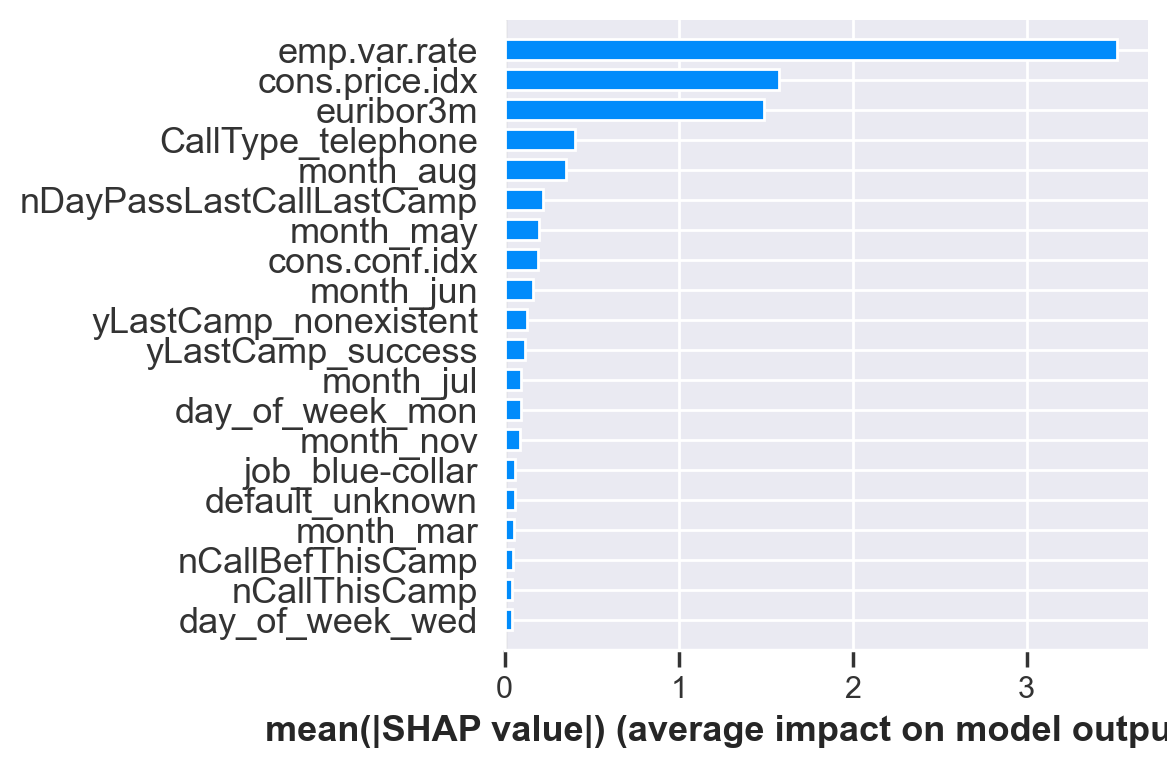

In [181]:
shap.summary_plot(shap_values, X_test.iloc[0:1000, : ], max_display=20, plot_type='bar', color_bar='husl', plot_size=(6,4))

 Insights:
 - The features are ordered by how much they influenced the model’s prediction. The x-axis stands for the average of the absolute SHAP value of each feature. 

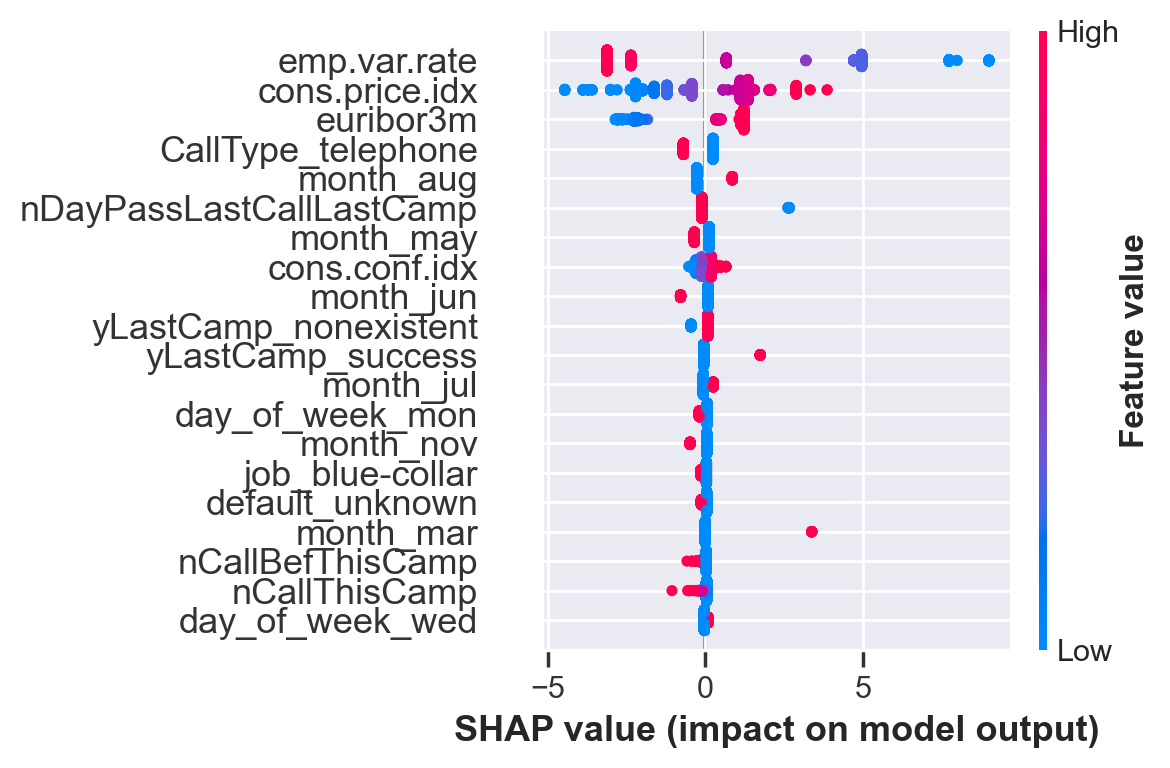

In [182]:
shap.summary_plot(shap_values, X_test.iloc[0:1000, : ], max_display=20, plot_size=(6,4))

In this chart, the x-axis stands for SHAP value, and the y-axis has all the features. Each point on the chart is one SHAP value for a prediction and feature. Red color means higher value of a feature. Blue means lower value of a feature. We can get the general sense of features’ directionality impact based on the distribution of the red and blue dots.

In [25]:
# shap.dependence_plot('emp.var.rate', shap_values, X_test.iloc[0:1000, : ], interaction_index="age")

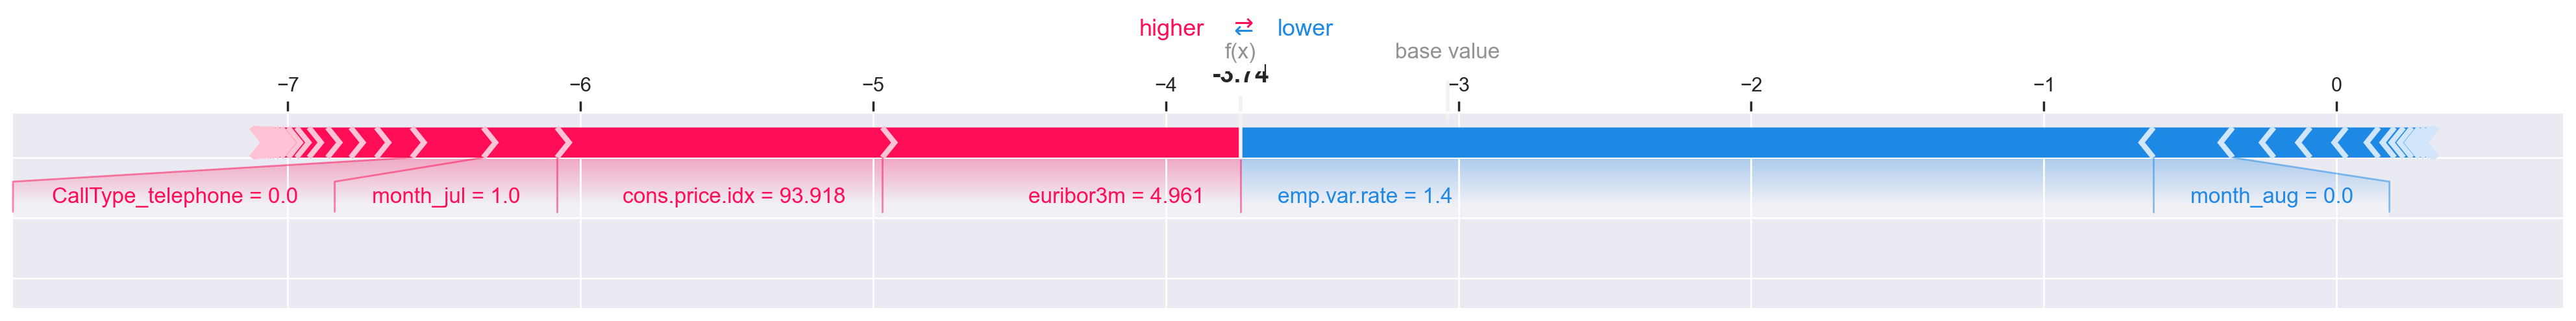

In [186]:
# Adding matplotlib=True in the function works as well
shap.force_plot(explainer.expected_value, shap_values[108, :], X_test.iloc[108, :], matplotlib=True)

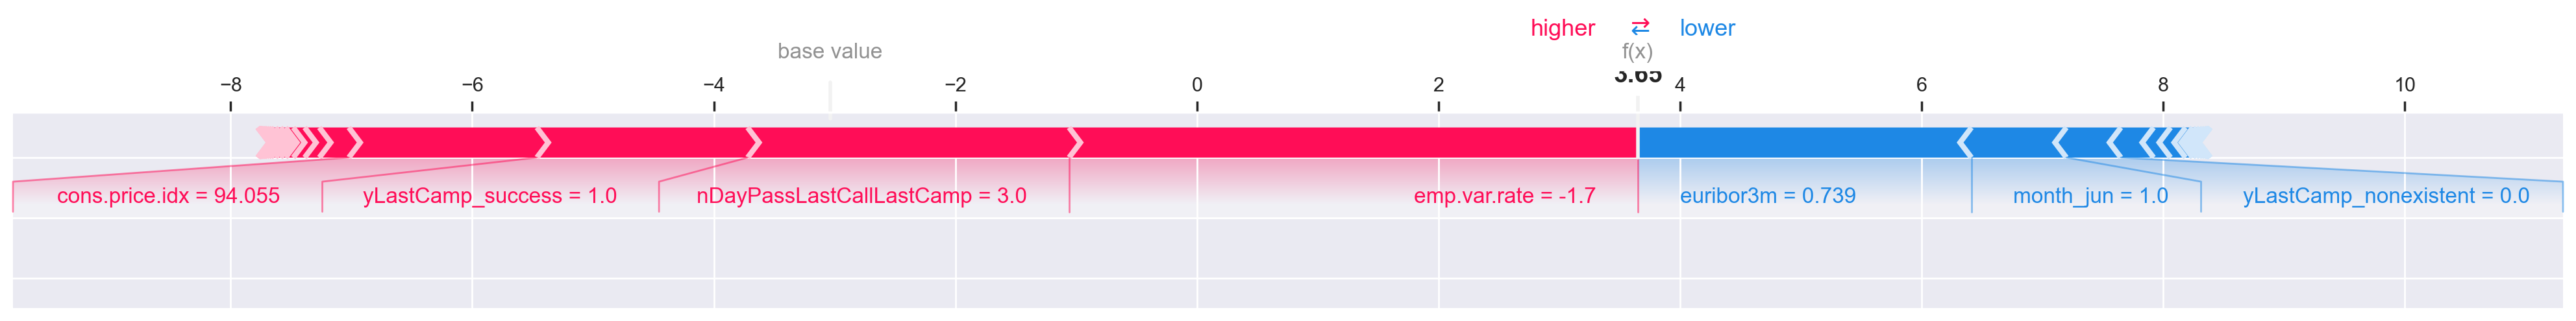

In [190]:
shap.force_plot(explainer.expected_value, shap_values[2, :], X_test.iloc[2, :],matplotlib=True)

In [189]:
# Uncomment following line to get information for the days iloc[101, :] and iloc[908, :]
# X_test.iloc[101, :]
# X_test.iloc[908, :]
y_test.iloc[108], y_test.iloc[2]

(0, 1)

Local interpretation by SHAP: we calculate SHAP values for 2 individual predictions selected randomly and see how the features contribute to that single prediction. 

In [53]:
# save and load the model model = pickle.load(open('LDA_final/BankCampaignModel.pkl.pkl','rb'))

with open('BankCampaignModel.pkl', 'wb') as file:
    pickle.dump(LDA_final, file)

# VI Conclusion and outlook

Key techniques used:
- Data cleaning, EDA, VIF, Correlation, Mutual information, PCA, TSNE, Stratified train test split, SmoteENN, Cross validation, Individual models, Voting models, ensemble models, Metircs and cut-off point selection, SHAP ect.

Main findings:
- Highest conversion rate factors (>0.2): for job (retired, student), yLastCamp ('illiterate'), months (april, december, march, september, october), yLastCamp ('success'). Lowest conversion rate factors (~ 0.05): default credit (unknown), calltype (telephone), month(may). W'd better to find out the possible reasons. 
- Euribor3m, cons.price.idx, emp.var.rate, euribor3m, nr.employed, nDayPassLastCallLastCamp, yLastCamp_nonexistent, nCallBefThisCamp. are highly correlated. 
- Duration(s), euribor3m, cons.conf.idx, cons.price.idx, nDayPassLastCallLastCamp, yLastCamp_success, nCallBefThisCamp. contribute positively to the success of the campaign. However, MI score values are very low (<0.07).
- PCA and SmoteENN are not helpful to increase model's performance for this dataset.
- The  best balanced model was LDA. Use a cut-off 0.1, for class 1: precision = 0.42, recall = 0.61, F1 = 0.5; for class 0: precision = 0.95, recall = 0.89, F1 = 0.92. We can chose other models according to the goals of campaign. 

Difficulty:
- Models training is time consuming on personal laptop.
- Organising split, pipeline, scale, smote, cv, pca etc need to be considered carefully.
- Improving model performance is taugh.

Other techniques can be tried:
- Factor analysis of mixed data. Prince is a Python package that covers all data scenarios, borrowing from its explanation:
All variables are numeric: use principal component analysis (prince.PCA)
Have a contingency table: use correspondence analysis (prince.CA)
Have more than 2 variables and they are all categorical: use multiple correspondence analysis (prince.MCA)
Have groups of categorical or numerical variables: use multiple factor analysis (prince.MFA)
Have both categorical and numerical variables: use factor analysis of mixed data (prince.FAMD)*
- Impute unknown values
- RFE feature selection
- Outliers detection by unsupervised learning 
- Other modeling algorithms: for example the one in article 'Customer Response Model in Direct Marketing: Solving the Problem of Unbalanced Dataset with a Balanced Support Vector Machine' 
- Deploying the model as an app on cloud and look at its feasibility.

ref. https://marc-deveaux.medium.com/4-classification-algorithms-to-deal-with-unbalanced-datasets-d034f575cd6a